# Application de modèles NLP, apprentissage sur la base 'Entendre La France', et évaluation sur la base des contributions

Ce notebook a pour but de classifier les contributions du Grand Débat en utilisant les contributions d'Entendre la France et leurs labels indiqués par les participants.

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import NLP_plots_models

from sklearn.utils import resample

from sklearn.utils import shuffle

from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud

from NLP_plots_models import wordcloud_decision
import os

## Imports

### Import de la base des contributions:

In [25]:
#df_author_contrib=pd.read_csv('Donnees_clean/contributions_auteur_unique/data_contrib_auteur_unique.csv')

In [26]:
#df_author_contrib.head()

authorId  \
0  VXNlcjo0M2E0MTFiYy0yMWFlLTExZTktOTRkMi1mYTE2M2...   
1  VXNlcjo0M2E0ZWNkNy0xZDg1LTExZTktOTRkMi1mYTE2M2...   
2  VXNlcjo0M2E2MWRiNS0yMjNkLTExZTktOTRkMi1mYTE2M2...   
3  VXNlcjo0M2E2ODg1MS0xZjBjLTExZTktOTRkMi1mYTE2M2...   
4  VXNlcjo0M2E3MTc2Yi0xZjI4LTExZTktOTRkMi1mYTE2M2...   

                                               texte  
0  proposition écolo La biodiversité et la dispar...  
1  vivre à la campagne La pollution de l'air Plus...  
2  Développement d'une conscience écologique indi...  
3  maintenant pas demain ! trop de strates La bio...  
4  la belle verte! public La biodiversité et la d...

**On peut importer directement la base des contributions pre-processées via lemmatisation:**

In [2]:
df_author_contrib=pd.read_csv('Donnees_clean/Models/contributions_preprocessed.csv')

In [30]:
#df_author_contrib.dropna(inplace=True)

### Import de la base 'Entendre La France': 

In [2]:
#Import de la base entendre la France avec informations sur chaque profil et tout le texte 'free' associé.
df_info_free=pd.read_csv('Donnees_clean/Entendre_La_France/info_free.csv')

In [3]:
df_info_free.head()

user_id                                             answer  code_postal  \
0    17816  C’est un point essentiel selon moi. Communique...      13200.0   
1    17942  Le regard &&De l hautre &&De ce qu il fait Un ...          NaN   
2    17943  Dites leur la vérité. Si une situation est jug...      10000.0   
3    17947  Rendre les actes ou paroles homophobe plus con...          NaN   
4    17948  Les conditions sont alarmique avec tout ces pe...       3320.0   

             commune type_commune         nom_departement departement   sexe  \
0         ARLES (13)       Urbain  Bouches-du-RhÃ´ne (13)          13  Homme   
1                NaN          NaN                     NaN         NaN    NaN   
2        TROYES (10)       Urbain               Aube (10)          10    NaN   
3                NaN          NaN                     NaN         NaN    NaN   
4  POUZY MESANGY (3)        Rural              Allier (3)           3    NaN   

         age formation                        profession    taille_org  \
0  25-34 ans  Bac +4/5  Cadre, profession intellectuelle  Plus de 5000   
1        NaN       NaN                               NaN           NaN   
2  45-54 ans       NaN                    Sans activitÃ©           NaN   
3        NaN       NaN                               NaN           NaN   
4  45-54 ans       NaN                               NaN           NaN   

       position_gj  
0  Ne soutient pas  
1              NaN  
2  Ne soutient pas  
3              NaN  
4         Soutient

## Modèles sur la base Entendre la France : 

### Position Gilets Jaunes 

#### Entrainement du modèle:

On ne prend que les profils pour lesquels on a la position Gilets Jaunes. 
Cette base de données:

- `features` = answer

- `target` = position_gj

Va nous servir de base de test pour l'apprentissage sur la base de données twitter.

In [13]:
print('Nombre de profils dont on connait la position gilets jaunes: ', df_info_free.position_gj.count())
print('Nombre de profils au total:', df_info_free.shape[0])
print('proportion: {prop:.2f}%'.format(prop=df_info_free.position_gj.count()/df_info_free.shape[0] * 100))

Nombre de profils dont on connait la position gilets jaunes:  5516
Nombre de profils au total: 10055
proportion: 54.86%


In [14]:
d={'answer' : df_info_free.answer, 'position_gj' : df_info_free.position_gj}
df_info_free_position_gj=pd.DataFrame(data=d)

In [15]:
df_info_free_position_gj.head()

answer      position_gj
0  C’est un point essentiel selon moi. Communique...  Ne soutient pas
1  Le regard &&De l hautre &&De ce qu il fait Un ...              NaN
2  Dites leur la vérité. Si une situation est jug...  Ne soutient pas
3  Rendre les actes ou paroles homophobe plus con...              NaN
4  Les conditions sont alarmique avec tout ces pe...         Soutient

Suppression des NaN sur la position_gj:

In [16]:
df_info_free_position_gj=df_info_free_position_gj.dropna(subset=['position_gj']).reset_index(drop=True)

In [17]:
df_info_free_position_gj.head()

answer           position_gj
0  C’est un point essentiel selon moi. Communique...       Ne soutient pas
1  Dites leur la vérité. Si une situation est jug...       Ne soutient pas
2  Les conditions sont alarmique avec tout ces pe...              Soutient
3  Accorder plus de parole à certains Que tous pa...  Participe activement
4  Sexisme au travail sala6 Site internet Taxer l...              Soutient

In [18]:
print('toutes les targets de la base : ', df_info_free_position_gj.position_gj.unique())
Targets=['Ne soutient pas','Soutient','Participe activement']

toutes les targets de la base :  ['Ne soutient pas' 'Soutient' 'Participe activement']


Preprocessing: **Avec Lemma**

In [19]:
df_info_free_position_gj['answer'] = df_info_free_position_gj['answer'].astype('str').apply(NLP_plots_models.clean_text_lemma)

On enregistre : 

In [20]:
#df_info_free_position_gj.to_csv('Donnees_clean/Models/ElF_position_gj_preprocessed_lemma.csv', index=False)

In [3]:
#df_info_free_position_gj=pd.read_csv('Donnees_clean/Models/ElF_position_gj_preprocessed_lemma.csv')

In [12]:
#df_info_free_position_gj.dropna(inplace=True)

In [14]:
#df_info_free_position_gj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5514 entries, 0 to 5515
Data columns (total 2 columns):
answer         5514 non-null object
position_gj    5514 non-null object
dtypes: object(2)
memory usage: 129.2+ KB


Initialisation de TF-IDF / Word-Embedding : 

In [21]:
# Initializing TFIDF :
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
#Attributs :
features = tfidf.fit_transform(df_info_free_position_gj.answer).toarray()
#Labels :
labels = df_info_free_position_gj.position_gj

Pie chart des position gilets jaunes: 

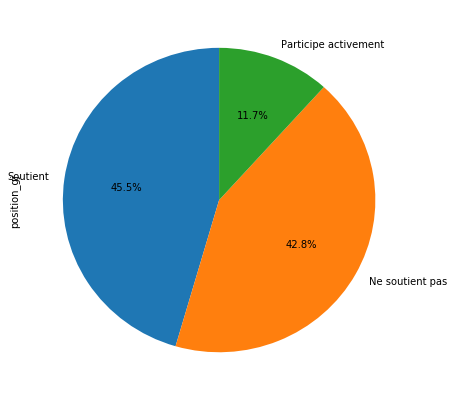

True

In [22]:
NLP_plots_models.partis_pie_chart(labels)

------------- SGDClassifier ----------------------------------------


C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

     Ne soutient pas       0.53      0.88      0.66       790
            Soutient       0.58      0.37      0.45       815
Participe activement       0.00      0.00      0.00       216

            accuracy                           0.55      1821
           macro avg       0.37      0.42      0.37      1821
        weighted avg       0.49      0.55      0.49      1821



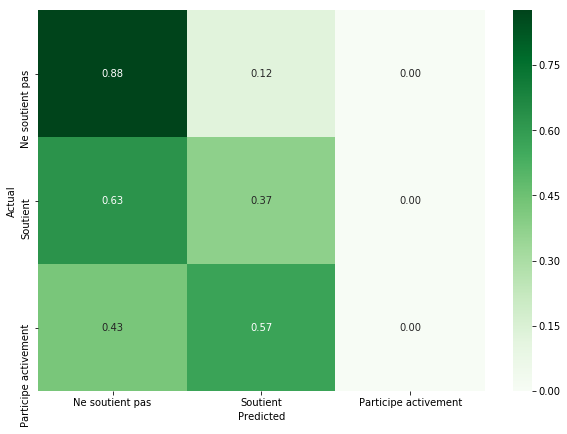

------------- RandomForestClassifier ----------------------------------------


C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

     Ne soutient pas       0.78      0.04      0.07       790
            Soutient       0.45      0.99      0.62       815
Participe activement       0.00      0.00      0.00       216

            accuracy                           0.46      1821
           macro avg       0.41      0.34      0.23      1821
        weighted avg       0.54      0.46      0.31      1821



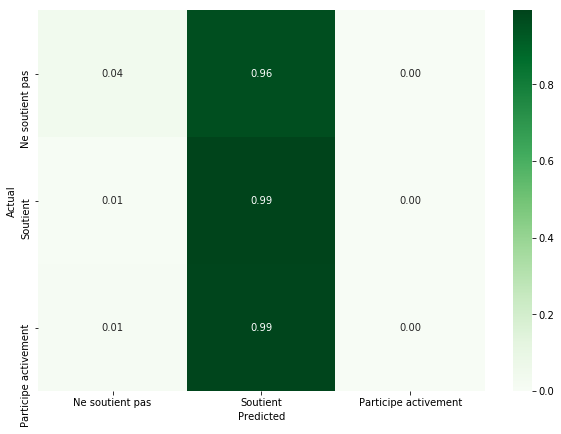

------------- LinearSVC ----------------------------------------
                      precision    recall  f1-score   support

     Ne soutient pas       0.58      0.61      0.59       790
            Soutient       0.51      0.60      0.55       815
Participe activement       0.28      0.04      0.07       216

            accuracy                           0.54      1821
           macro avg       0.46      0.42      0.41      1821
        weighted avg       0.51      0.54      0.51      1821



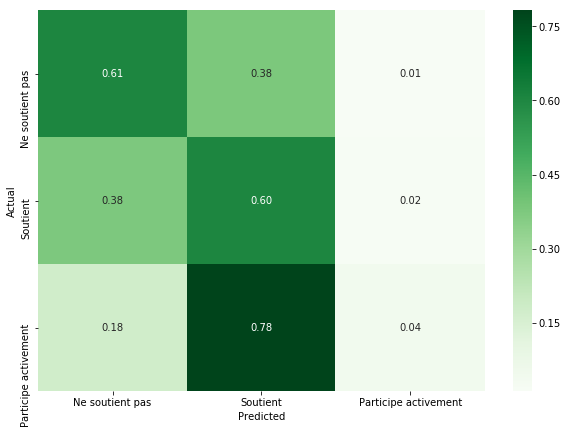

------------- MultinomialNB ----------------------------------------


C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                      precision    recall  f1-score   support

     Ne soutient pas       0.68      0.51      0.58       790
            Soutient       0.52      0.79      0.63       815
Participe activement       0.00      0.00      0.00       216

            accuracy                           0.57      1821
           macro avg       0.40      0.43      0.40      1821
        weighted avg       0.53      0.57      0.53      1821



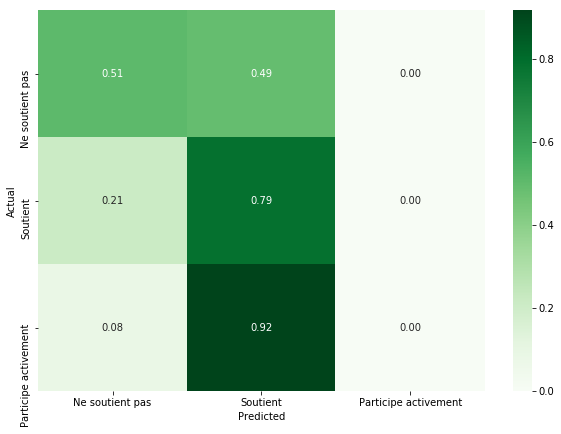

C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

------------- LogisticRegression ----------------------------------------
                      precision    recall  f1-score   support

     Ne soutient pas       0.62      0.62      0.62       790
            Soutient       0.53      0.66      0.59       815
Participe activement       1.00      0.00      0.01       216

            accuracy                           0.57      1821
           macro avg       0.72      0.43      0.41      1821
        weighted avg       0.62      0.57      0.53      1821



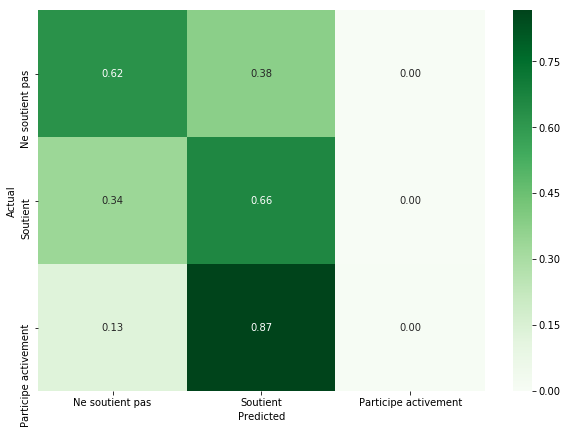

------------- DecisionTreeClassifier ----------------------------------------
                      precision    recall  f1-score   support

     Ne soutient pas       0.58      0.17      0.26       790
            Soutient       0.46      0.89      0.61       815
Participe activement       0.29      0.02      0.04       216

            accuracy                           0.47      1821
           macro avg       0.44      0.36      0.30      1821
        weighted avg       0.49      0.47      0.39      1821



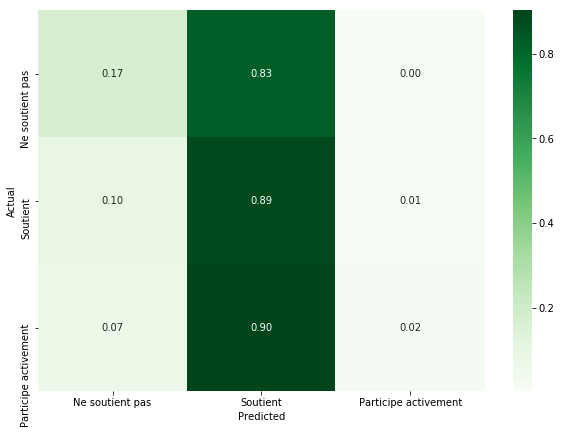

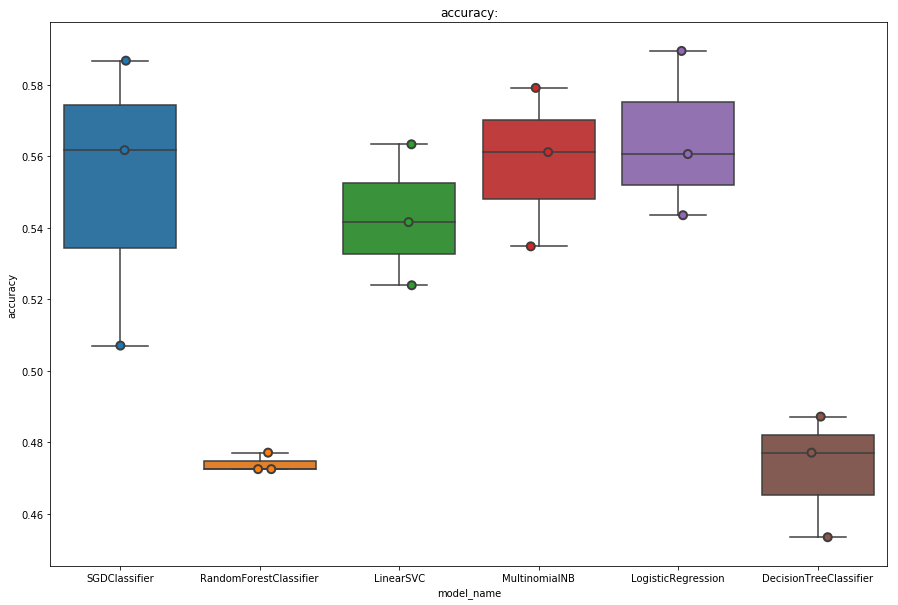

Accuracy:
model_name
DecisionTreeClassifier    0.472626
LinearSVC                 0.542962
LogisticRegression        0.564536
MultinomialNB             0.558371
RandomForestClassifier    0.474076
SGDClassifier             0.551841
Name: accuracy, dtype: float64


True

In [23]:
NLP_plots_models.multi_models_test(features, labels, CV=3)

#### Après Sur-échantillonnage:

In [15]:
# separate minority and majority classes
Oui = df_info_free_position_gj[df_info_free_position_gj.position_gj=='Soutient']
Non = df_info_free_position_gj[df_info_free_position_gj.position_gj=='Ne soutient pas']
Participe=df_info_free_position_gj[df_info_free_position_gj.position_gj=='Participe activement']

# upsample minority 'Ne soutient pas'
Non_upsampled = resample(Non,
                          replace=True, # sample with replacement
                          n_samples=len(Oui), # match number in majority class
                          random_state=27) # reproducible results
# upsample minority 'Participe activement'
Participe_upsampled = resample(Participe,
                          replace=True, # sample with replacement
                          n_samples=len(Oui), # match number in majority class
                          random_state=27) # reproducible results


In [16]:
# combine majority and upsampled minority
upsampled_position_gj = pd.concat([Oui, Non_upsampled, Participe_upsampled])
# On Shuffle le dataset:
upsampled_position_gj = shuffle(upsampled_position_gj)

In [17]:
print('Nombre d\'individus dans la base upsmapled:',upsampled_position_gj.shape[0])
print("Nombre de soutients des gilets jaunes dans le set upsampled: ", upsampled_position_gj[upsampled_position_gj.position_gj=='Soutient'].shape[0])
print("Nombre de personnes ne soutenant pas les gilets jaunes dans le set upsampled: ", upsampled_position_gj[upsampled_position_gj.position_gj=='Ne soutient pas'].shape[0])
print("Nombre de personnes 'participant activement' dans le set upsampled: ", upsampled_position_gj[upsampled_position_gj.position_gj=='Participe activement'].shape[0])

Nombre d'individus dans la base upsmapled: 7527
Nombre de soutients des gilets jaunes dans le set upsampled:  2509
Nombre de personnes ne soutenant pas les gilets jaunes dans le set upsampled:  2509
Nombre de personnes 'participant activement' dans le set upsampled:  2509


On a maintenant un set intitulé `upsampled` contenant autant de femmes que d'hommes.

In [18]:
# Initializing TFIDF :
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))
#Attributs :
features = tfidf.fit_transform(upsampled_position_gj.answer).toarray()
#Labels :
labels = upsampled_position_gj.position_gj

Vérification via Pie Chart :

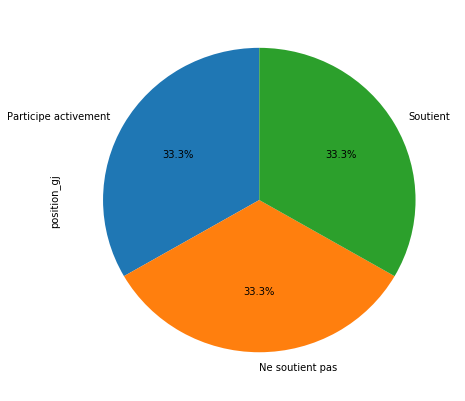

True

In [19]:
NLP_plots_models.partis_pie_chart(labels)

------------- SGDClassifier ----------------------------------------
                      precision    recall  f1-score   support

Participe activement       0.71      0.92      0.80       825
     Ne soutient pas       0.65      0.84      0.73       840
            Soutient       0.72      0.30      0.42       820

            accuracy                           0.69      2485
           macro avg       0.69      0.68      0.65      2485
        weighted avg       0.69      0.69      0.65      2485



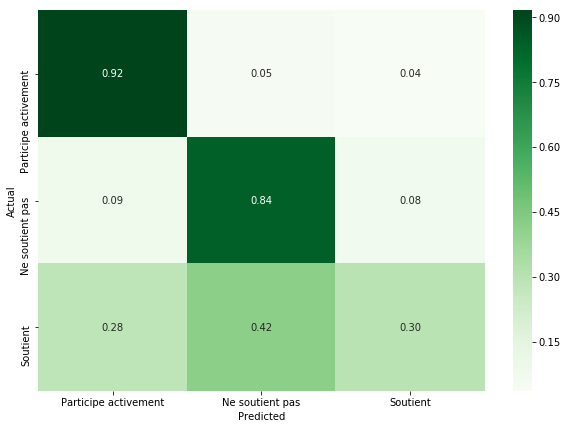

------------- RandomForestClassifier ----------------------------------------
                      precision    recall  f1-score   support

Participe activement       0.57      0.85      0.68       825
     Ne soutient pas       0.66      0.40      0.50       840
            Soutient       0.52      0.47      0.49       820

            accuracy                           0.57      2485
           macro avg       0.58      0.57      0.56      2485
        weighted avg       0.58      0.57      0.56      2485



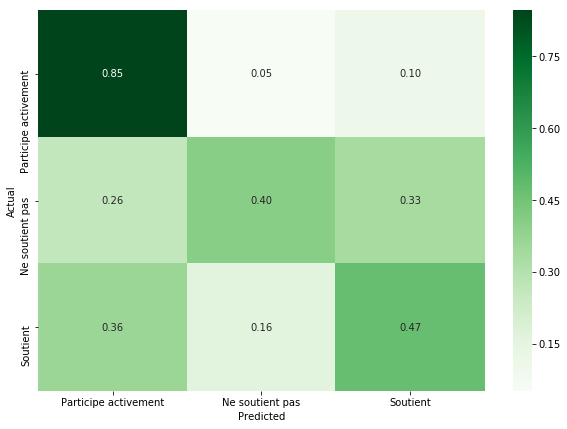

------------- LinearSVC ----------------------------------------
                      precision    recall  f1-score   support

Participe activement       0.89      0.94      0.91       825
     Ne soutient pas       0.75      0.76      0.75       840
            Soutient       0.71      0.65      0.68       820

            accuracy                           0.78      2485
           macro avg       0.78      0.78      0.78      2485
        weighted avg       0.78      0.78      0.78      2485



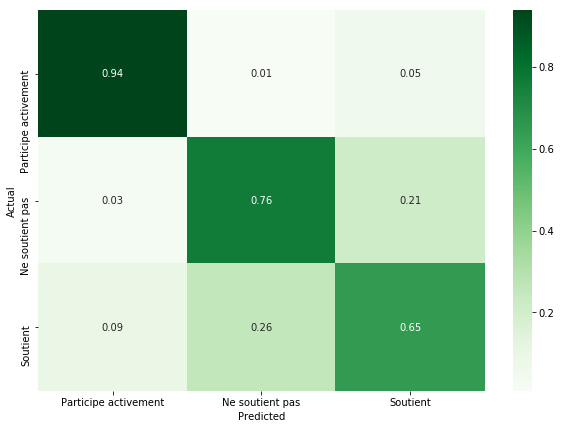

------------- MultinomialNB ----------------------------------------
                      precision    recall  f1-score   support

Participe activement       0.96      0.57      0.72       825
     Ne soutient pas       0.81      0.60      0.69       840
            Soutient       0.52      0.87      0.65       820

            accuracy                           0.68      2485
           macro avg       0.76      0.68      0.68      2485
        weighted avg       0.76      0.68      0.69      2485



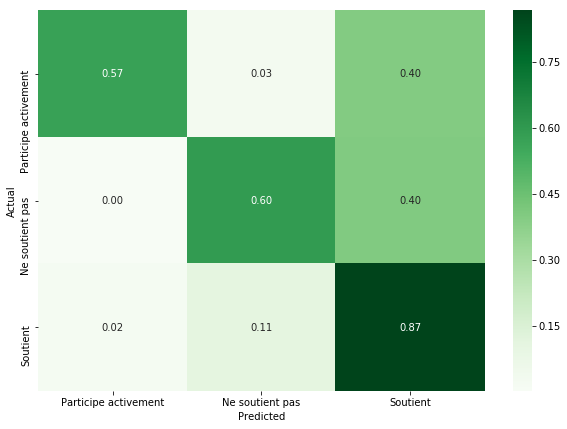

C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

------------- LogisticRegression ----------------------------------------
                      precision    recall  f1-score   support

Participe activement       0.80      0.89      0.84       825
     Ne soutient pas       0.73      0.74      0.73       840
            Soutient       0.65      0.57      0.61       820

            accuracy                           0.73      2485
           macro avg       0.73      0.73      0.73      2485
        weighted avg       0.73      0.73      0.73      2485



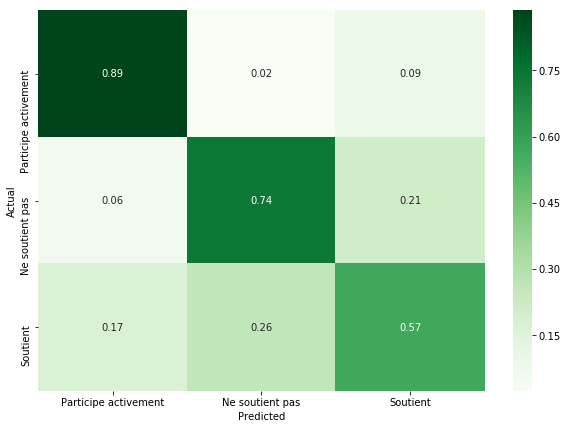

------------- DecisionTreeClassifier ----------------------------------------
                      precision    recall  f1-score   support

Participe activement       0.67      0.33      0.44       825
     Ne soutient pas       0.40      0.93      0.56       840
            Soutient       0.54      0.09      0.16       820

            accuracy                           0.46      2485
           macro avg       0.54      0.45      0.39      2485
        weighted avg       0.54      0.46      0.39      2485



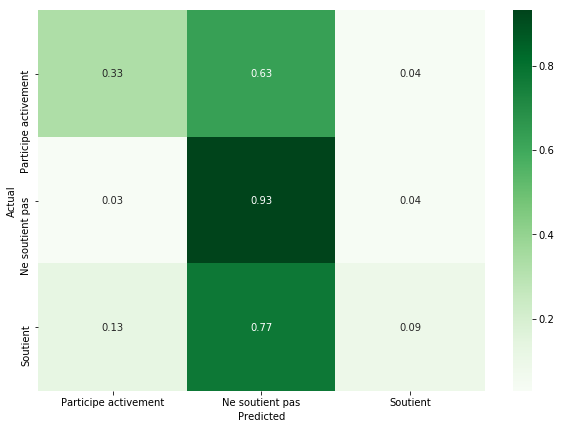

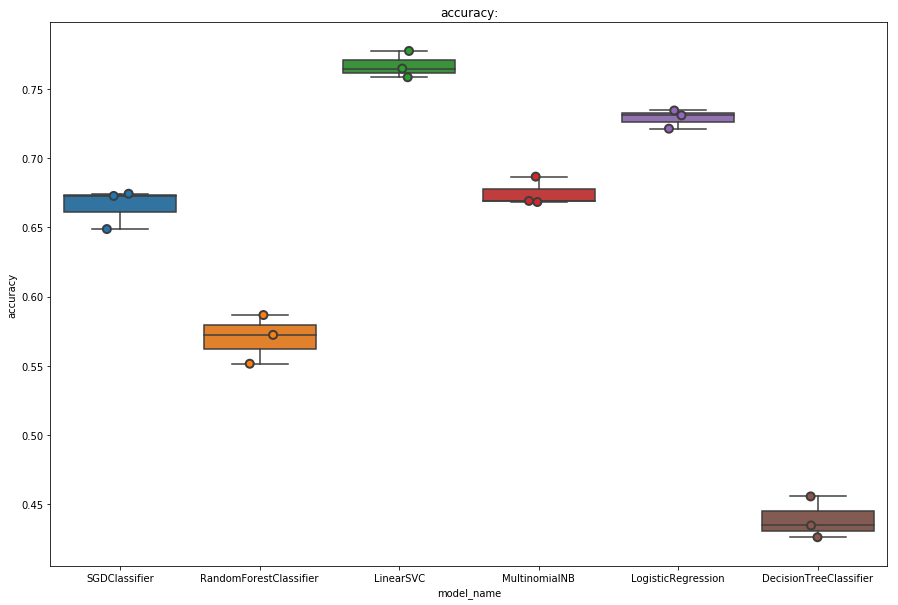

Accuracy:
model_name
DecisionTreeClassifier    0.438777
LinearSVC                 0.766796
LogisticRegression        0.728819
MultinomialNB             0.674632
RandomForestClassifier    0.570112
SGDClassifier             0.665199
Name: accuracy, dtype: float64


True

In [29]:
NLP_plots_models.multi_models_test(features, labels, CV=3)

#### Application sur les contributions:

On met une colonne 'train' pour savoir si la ligne fait partie de l'entrainement ou du test (1 entrainement, 0 test)

On utilise, étant donné les résultats de classification, la base de données 'sur-échantillonnée'

In [208]:
df_author_contrib['train']=0
upsampled_position_gj['train']=1

Concaténation des training et test sets pour pouvoir appliquer TF-IDF : 

In [209]:
#Pour simplifier, comme on ne connait pas le parti des contributeurs on leur attribut la valeur 0
df_author_contrib['party']=0

In [210]:
# création des données : d'abord les contributions puis la base de données d'apprentissage
d={"texte" : pd.concat([df_author_contrib.texte, upsampled_position_gj.answer], axis=0), 
   
   "party" : pd.concat([df_author_contrib.party,upsampled_position_gj.position_gj], axis=0),
   
   "train" : pd.concat([df_author_contrib.train, upsampled_position_gj.train], axis=0) 
}
df_all=pd.DataFrame(data=d)

##### TFIDF :

In [211]:
# Initializing TFIDF :
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), dtype='float32')
#Attributs :
tfidf.fit(df_all.texte)

C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1616: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float32 'dtype' will be converted to np.float64.
  UserWarning)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype='float32', encoding='latin-1', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=5,
                ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [212]:
features_contrib = tfidf.transform(df_all.texte)

##### Entrainement du modèle :

On divise entre training/test sets :

In [213]:
features_contrib_train= features_contrib[-upsampled_position_gj.shape[0]:,:]
features_contrib_test= features_contrib[:df_author_contrib.shape[0]:,:]

In [214]:
labels=upsampled_position_gj.position_gj

##### Avec LinearSVC

In [215]:
#initialisation du modèle :
model=LinearSVC()

In [216]:
#On fit le modèle :
model.fit(features_contrib_train, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

###### Application du modèle :

In [217]:
label_pred = model.predict(features_contrib_test)

###### Résultats :

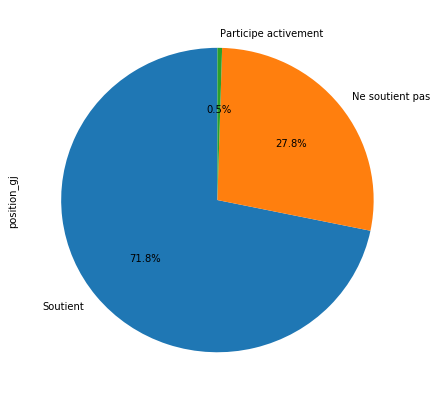

True

In [218]:
#Pour pouvoir utiliser la fonction, on le convertit en dataframe
d={'position_gj' : label_pred}
label_pred=pd.DataFrame(data=d)

#On affiche le pie chart :
NLP_plots_models.partis_pie_chart(label_pred.position_gj)

On enregistre les classifications:

In [219]:
#label_pred.to_csv('Donnees_clean/Classifications/predictions_gj_linearSVC.csv', index=False)

In [220]:
def wordcloud_decision(model, features,df):
    #On appelle la decision_function : 
    labels_decision_function=model.decision_function(features)
    #On cherche les labels tels que définis dans la modèle:
    Labels=model.classes_
    
    df2=df.reset_index()
    for i, label in enumerate(Labels):
        s=pd.Series(abs(labels_decision_function[:,i]))
        #On définit le texte:
        text=df2.texte[s <= np.sort(abs(labels_decision_function[:,i]))[100]]
        
        #On définit le nuage:
        cloud = WordCloud(stopwords=['oui', 'non', 'qu', 'est'], background_color='black',
                                  collocations=False,
                                  width=2500,
                                  height=1800
                                 ).generate(" ".join(text))
        
        plt.figure(figsize=(40,25))
        plt.axis('off')
        plt.title(label, size=50)
        plt.imshow(cloud)
    return None

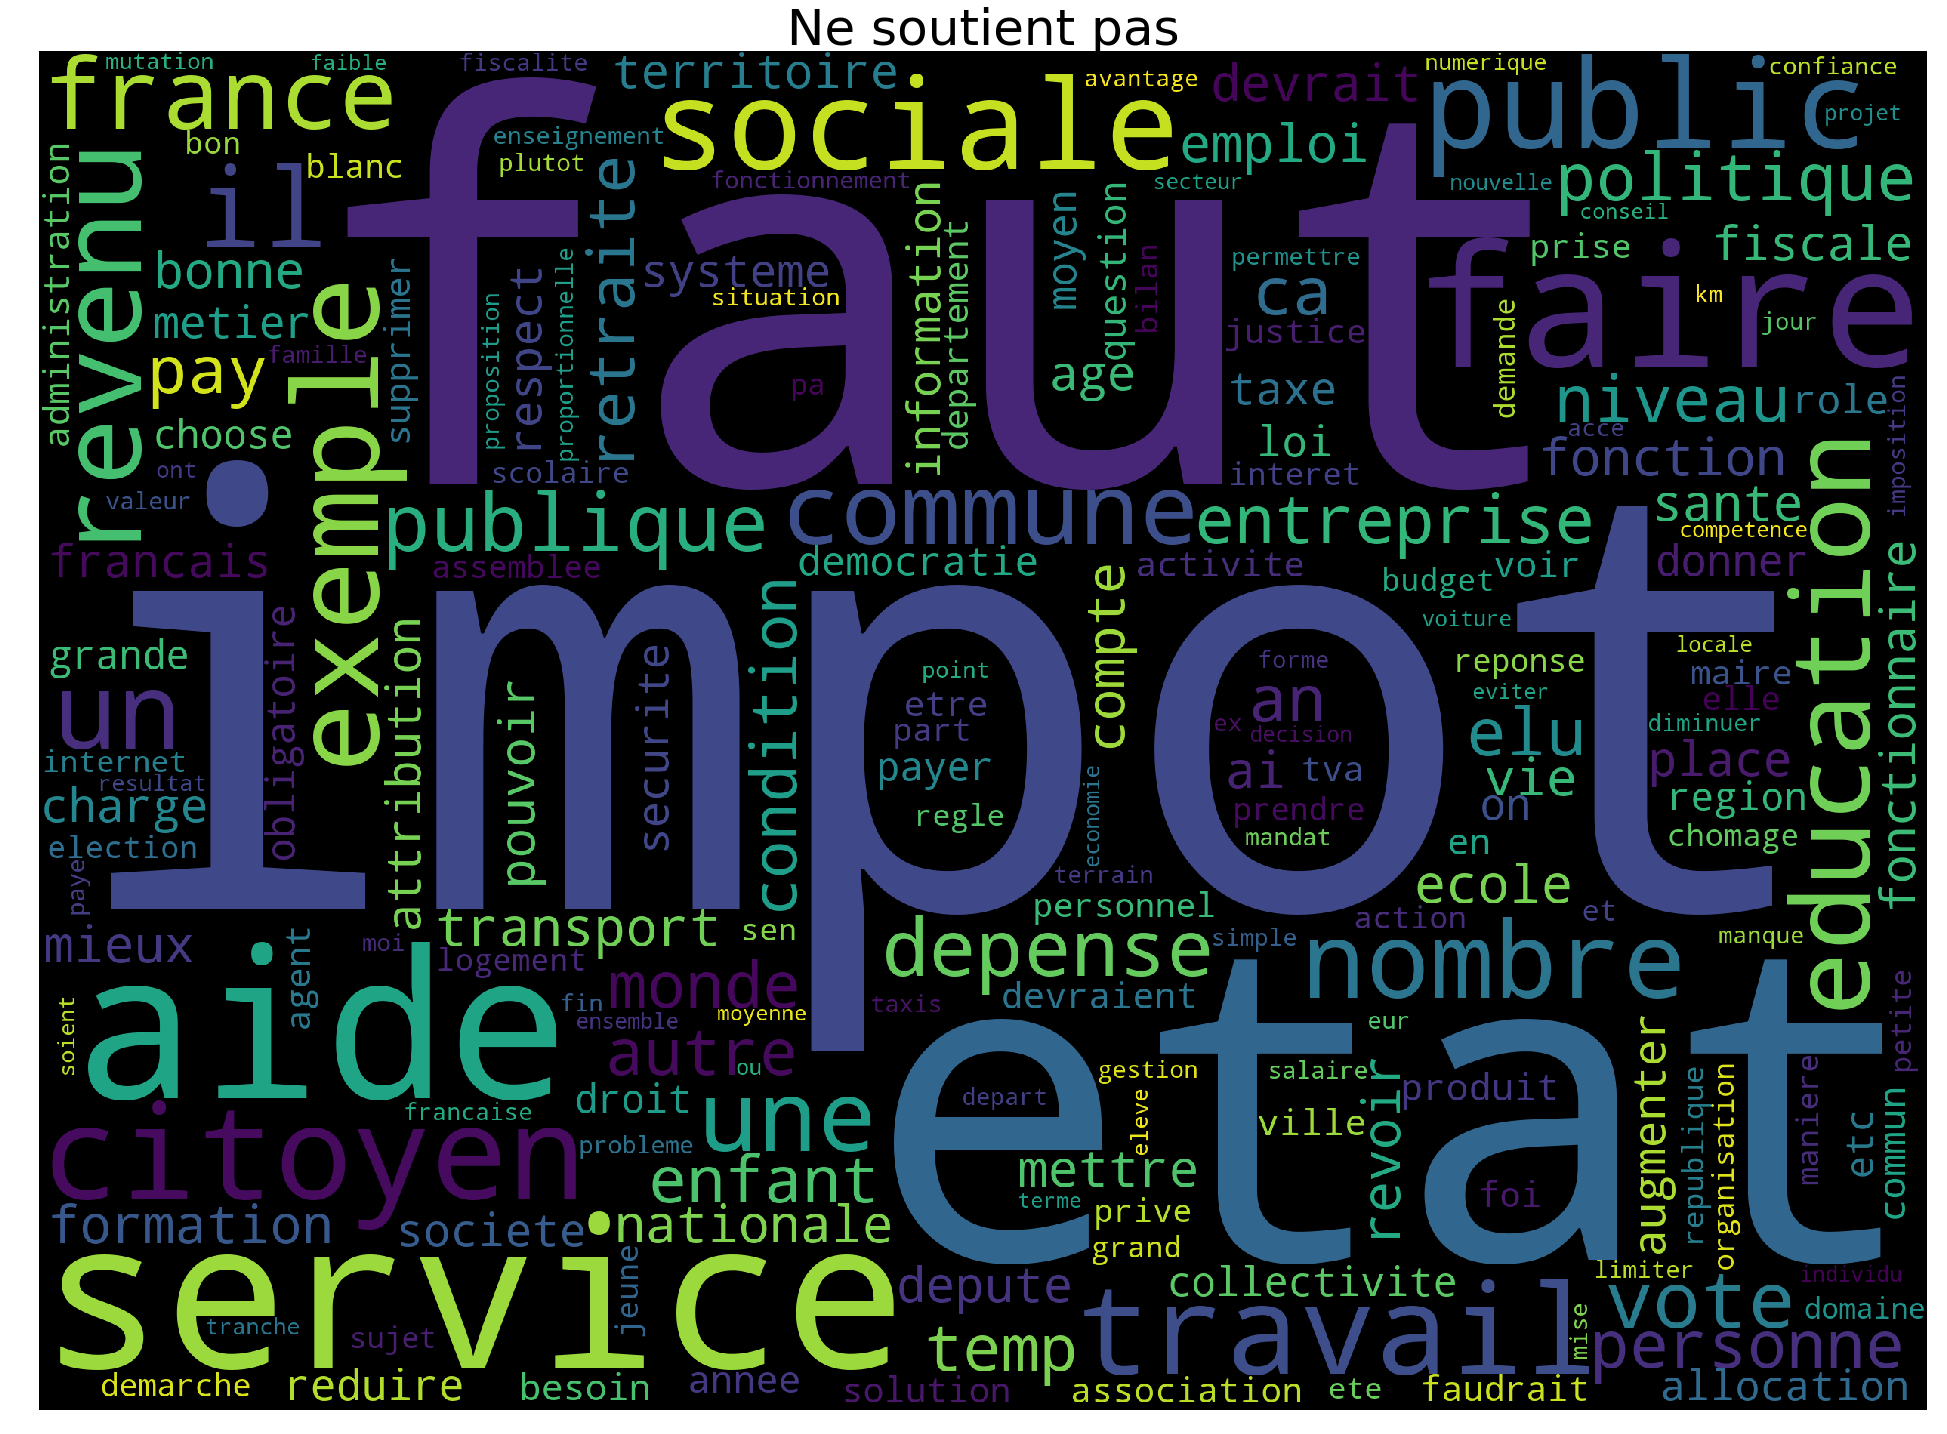

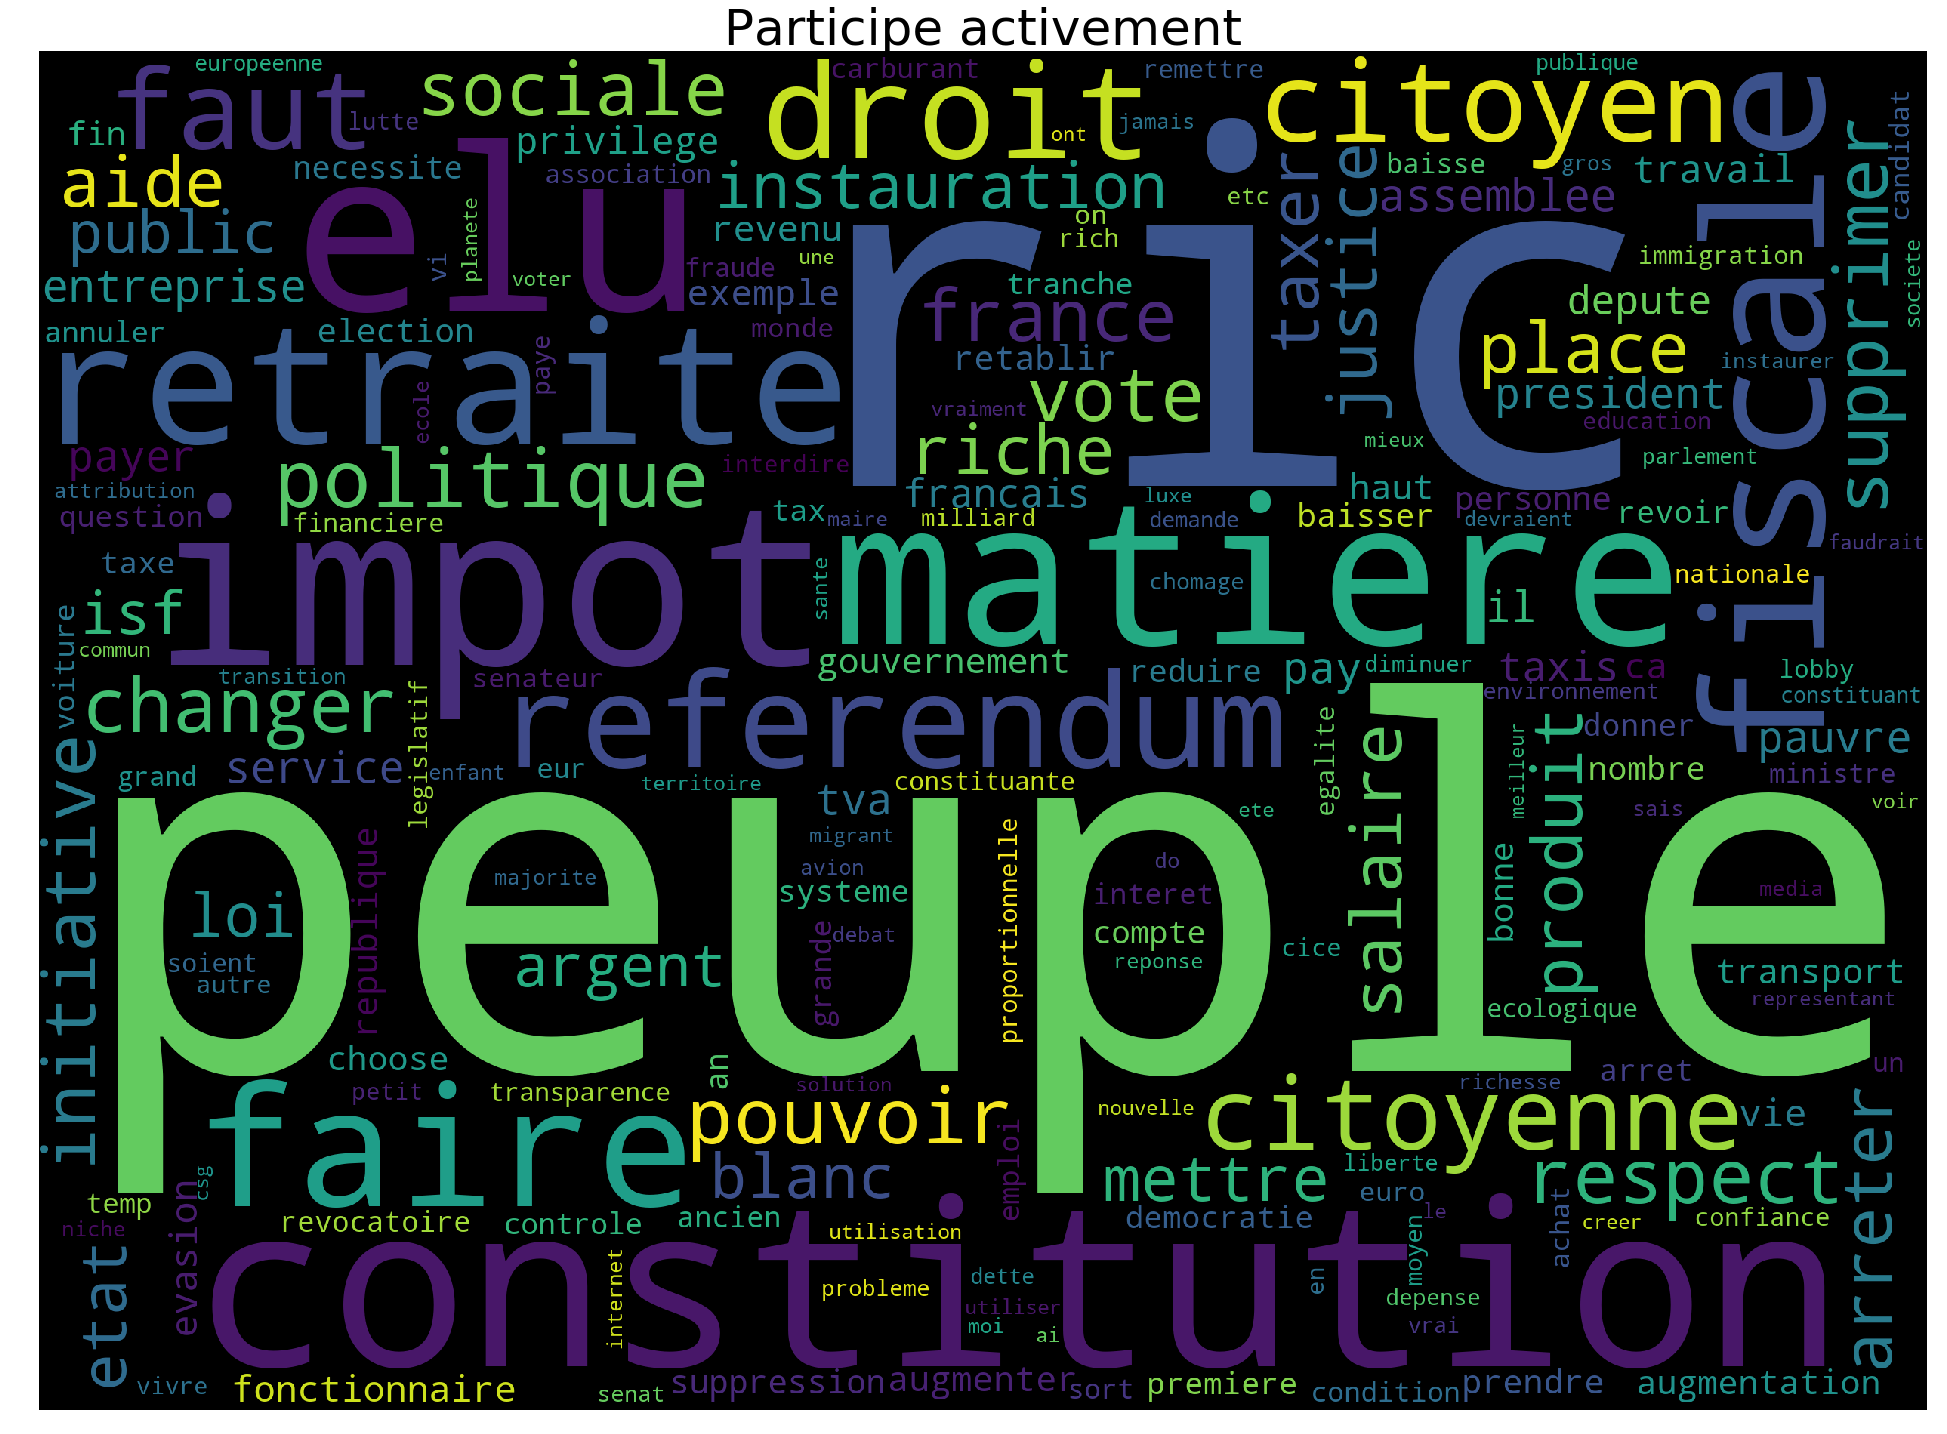

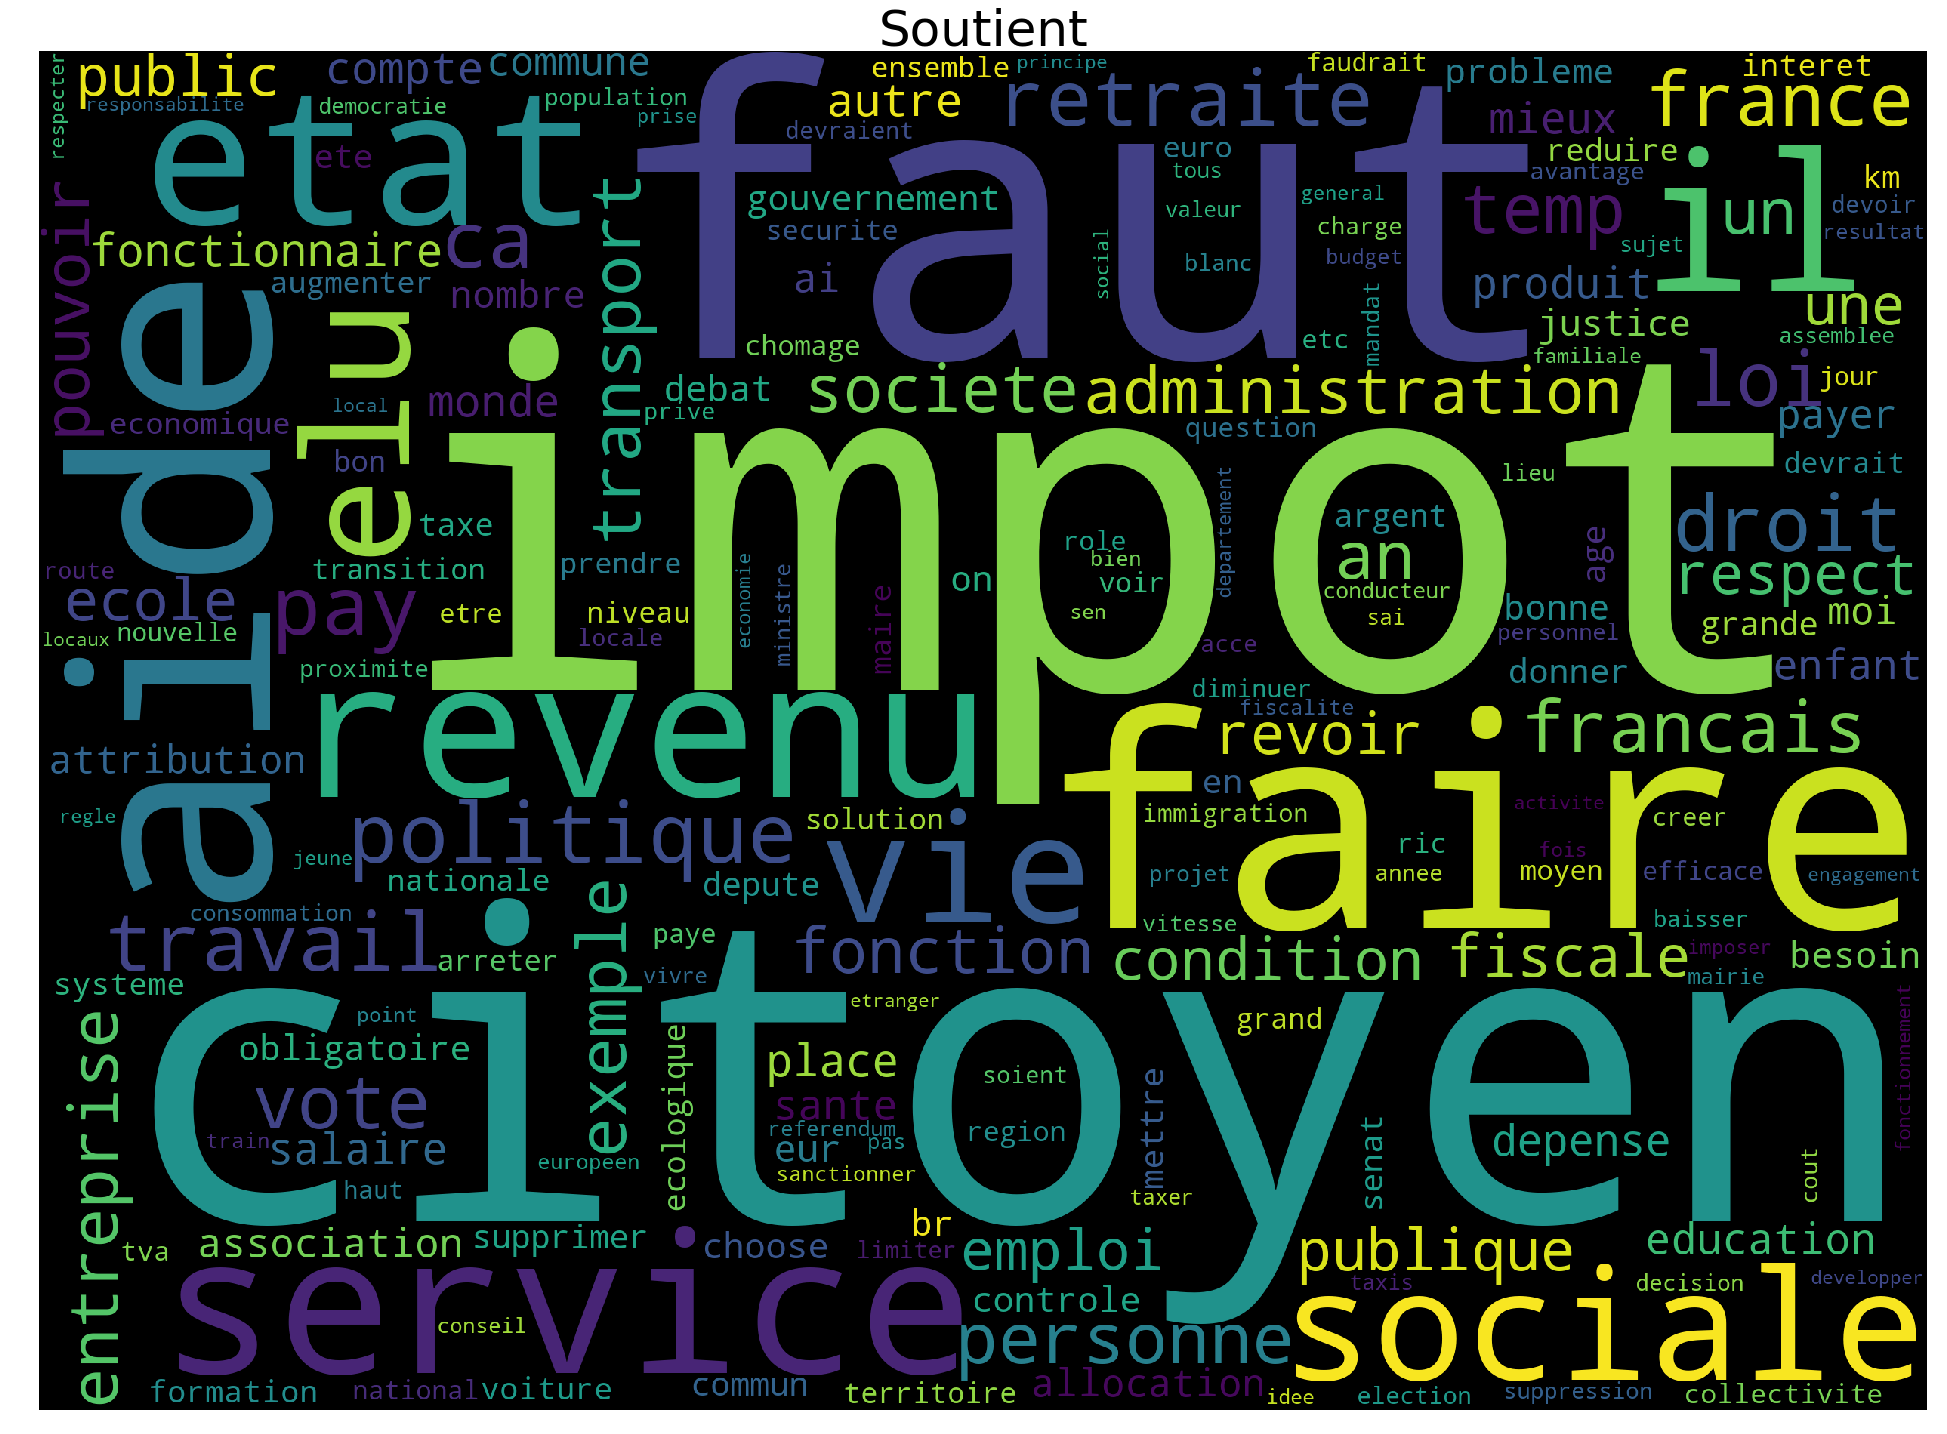

In [221]:
wordcloud_decision(model,features_contrib_test, df_author_contrib)

##### Avec Régression Logistique:

In [222]:
#initialisation du modèle :
model=LogisticRegression()

In [223]:
#On fit le modèle :
model.fit(features_contrib_train, labels)

C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adrie\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

###### Application du modèle :

In [224]:
label_pred = model.predict(features_contrib_test)

###### Résultats :

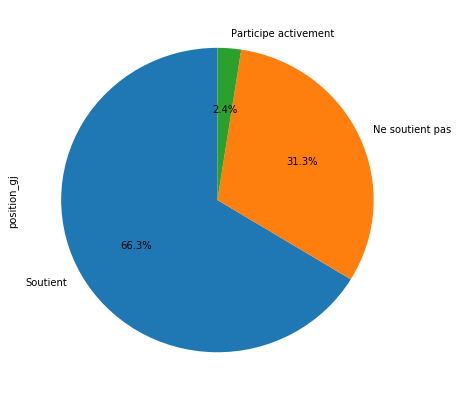

True

In [225]:
#Pour pouvoir utiliser la fonction, on le convertit en dataframe
d={'position_gj' : label_pred}
label_pred=pd.DataFrame(data=d)

#On affiche le pie chart :
NLP_plots_models.partis_pie_chart(label_pred.position_gj)

On enregistre les classifications:

In [124]:
#label_pred.to_csv('Donnees_clean/Classifications/predictions_gj_LogReg.csv', index=False)

**Wordcloud:**

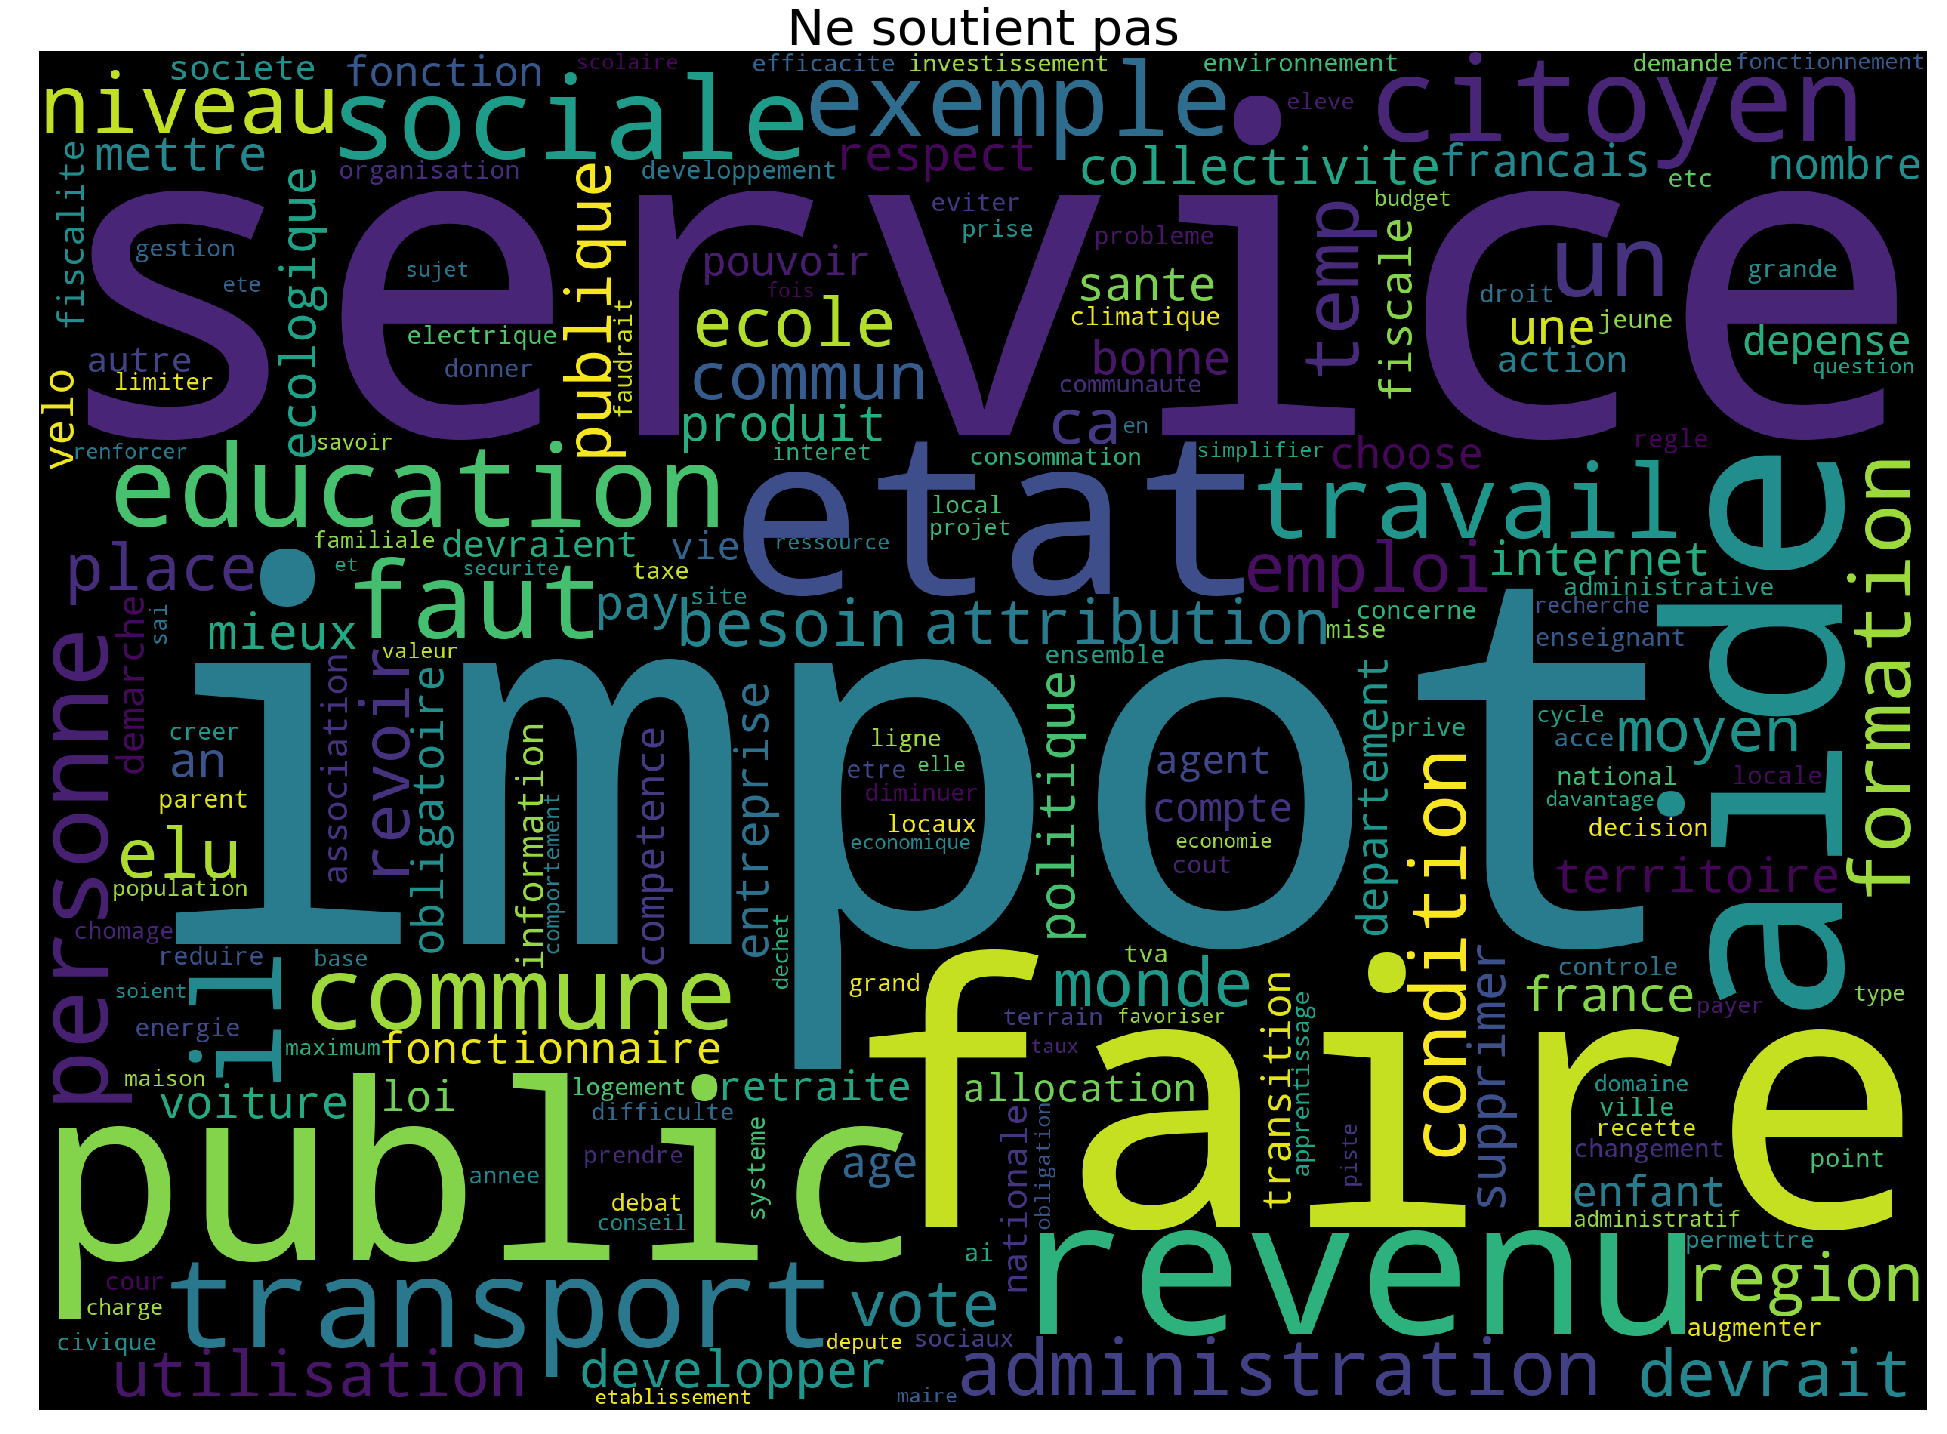

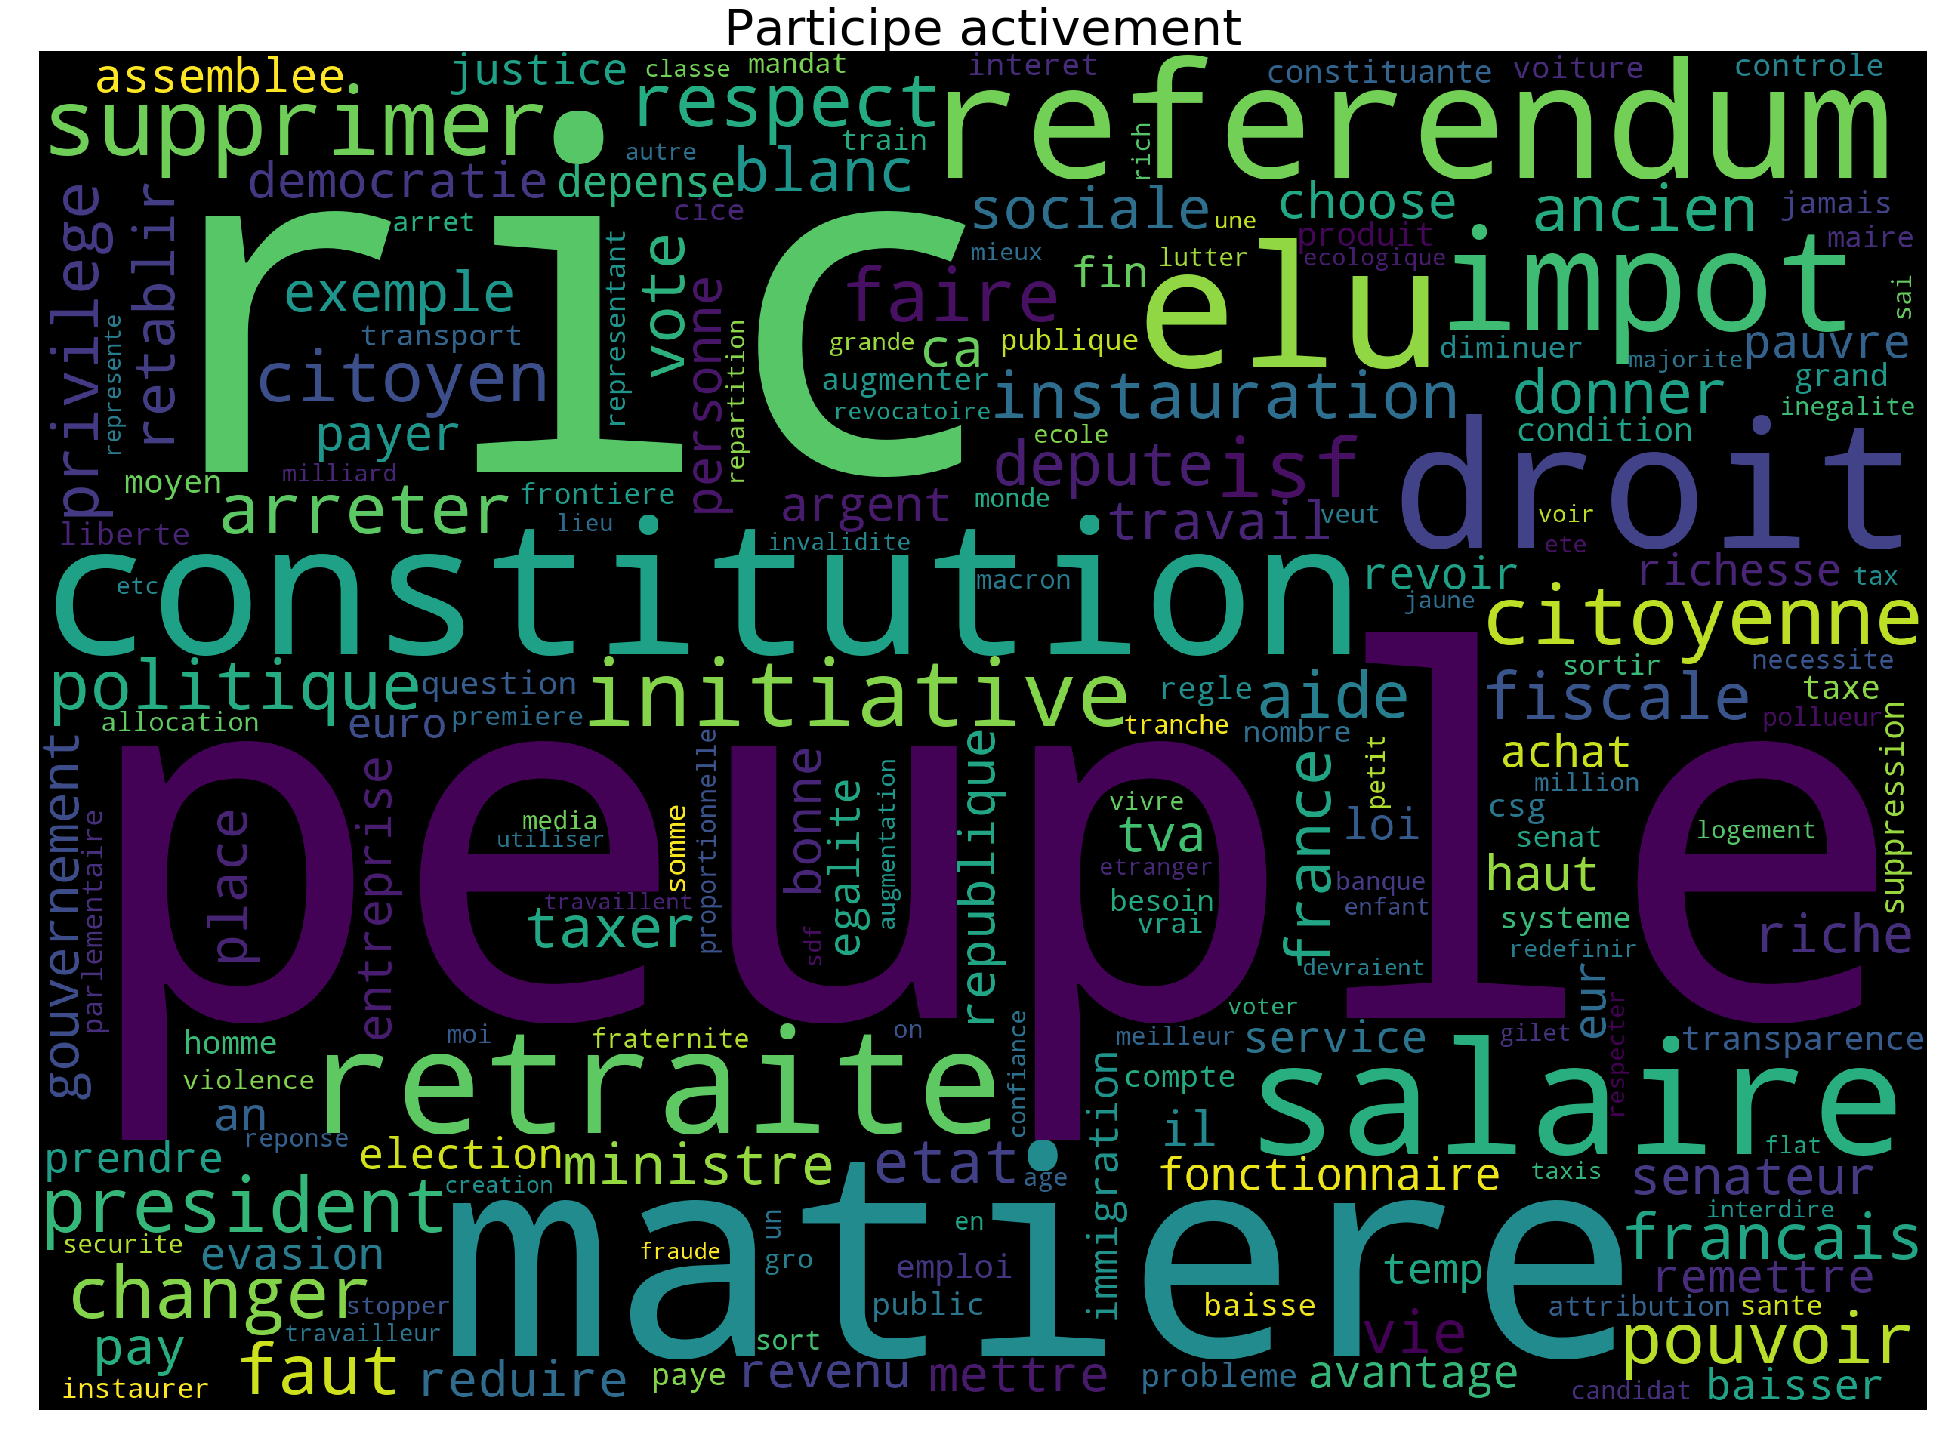

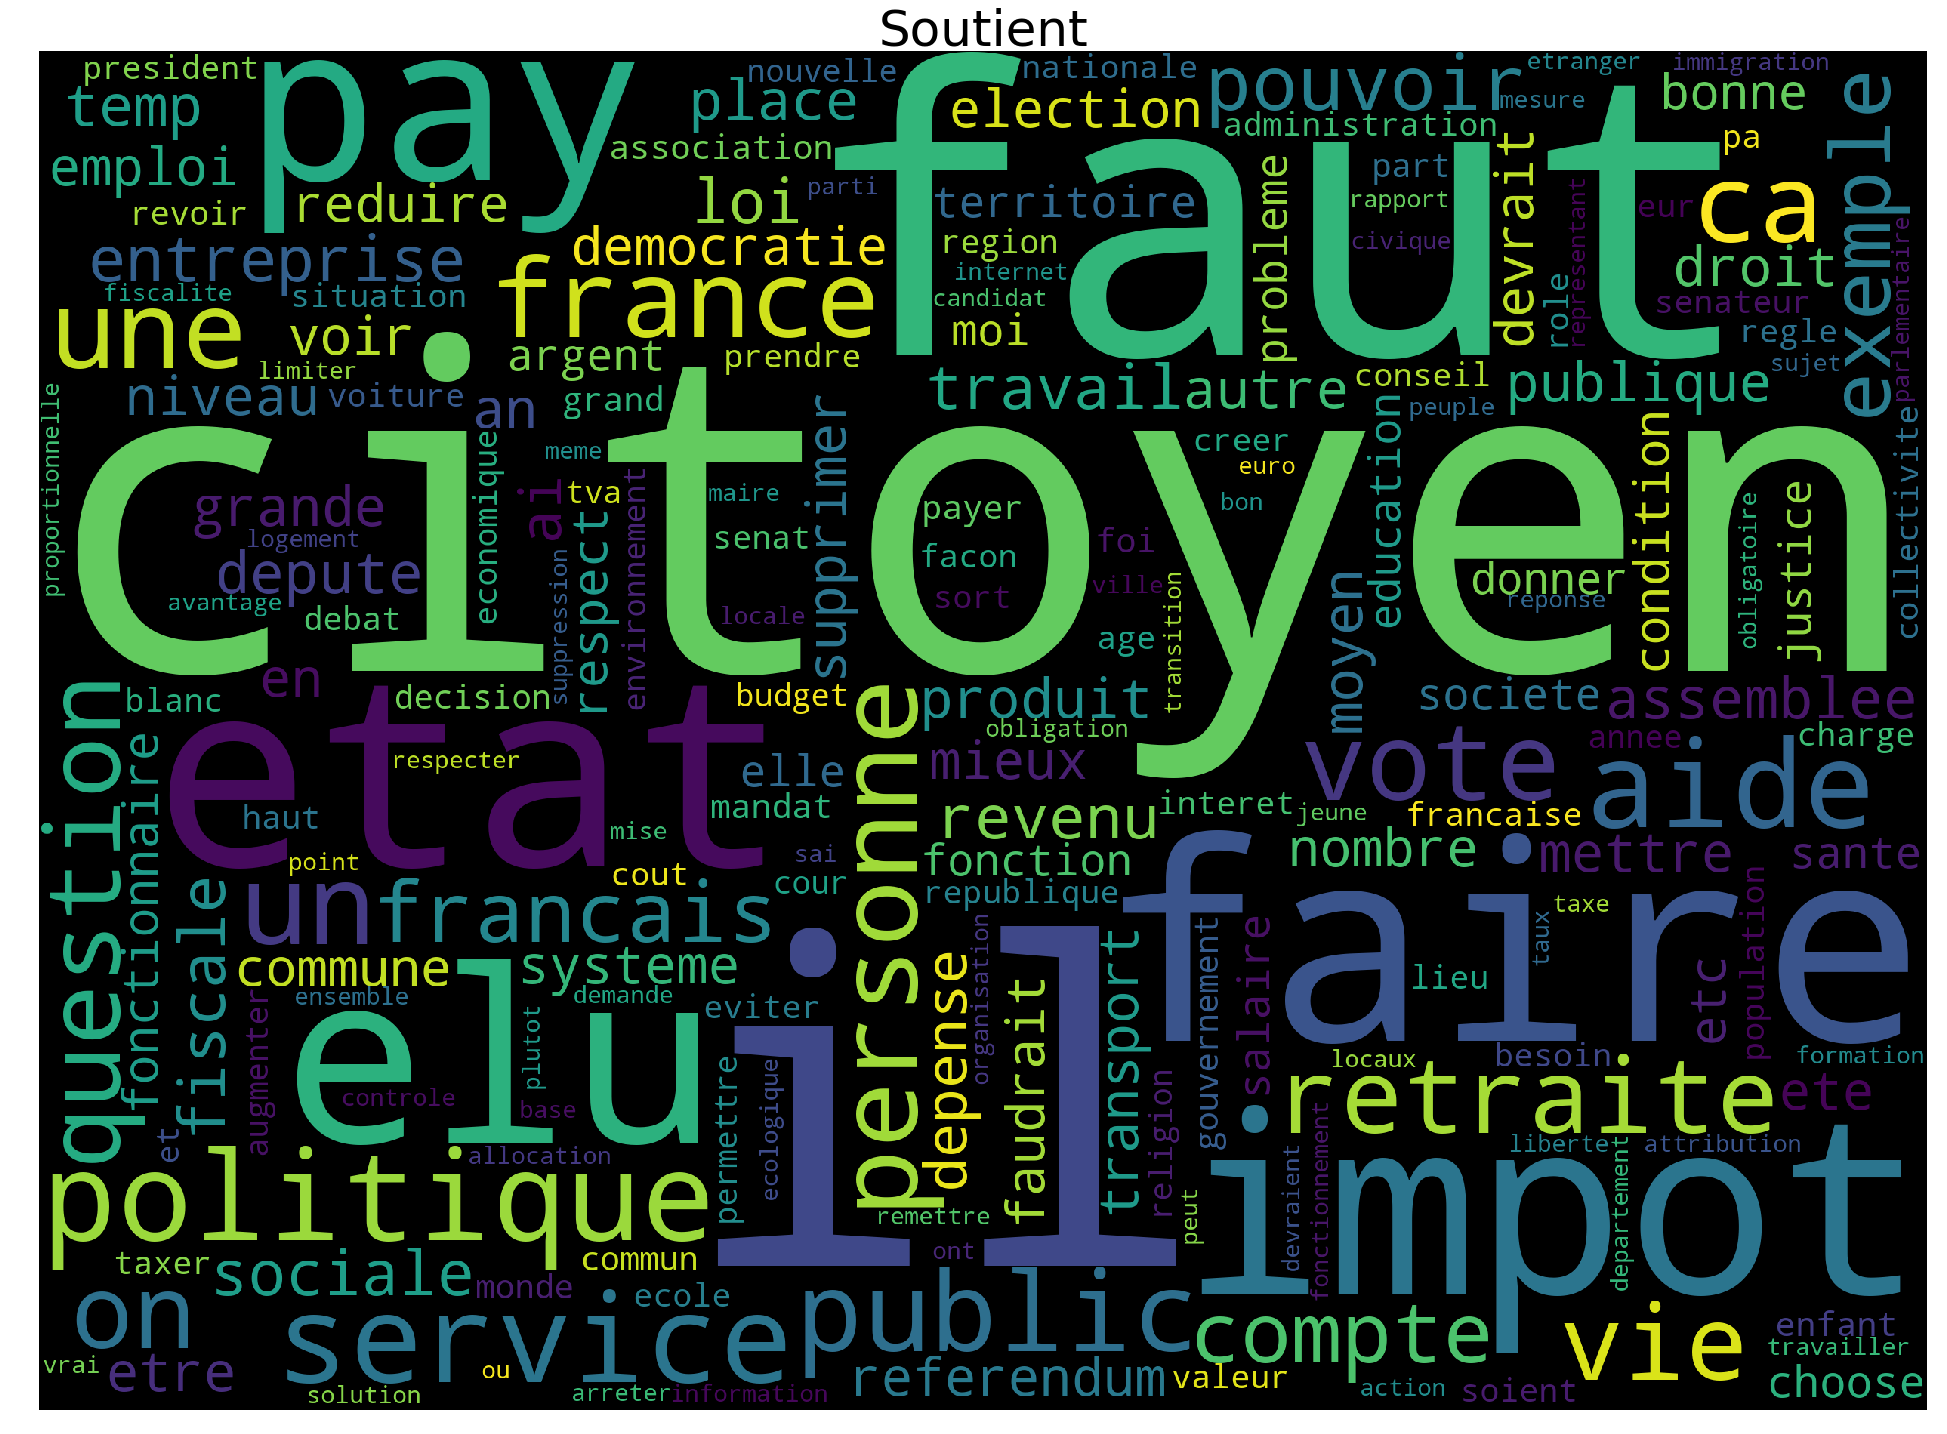

In [226]:
wordcloud_decision(model,features_contrib_test, df_author_contrib)

##### Avec SGD :  

In [227]:
#initialisation du modèle :
model=SGDClassifier()

In [228]:
#On fit le modèle :
model.fit(features_contrib_train, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

###### Application du modèle :

In [229]:
label_pred = model.predict(features_contrib_test)

###### Résultats :

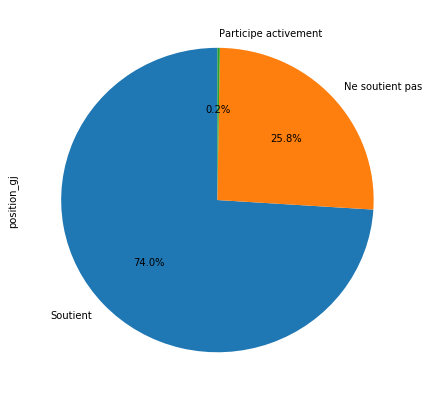

True

In [230]:
#Pour pouvoir utiliser la fonction, on le convertit en dataframe
d={'position_gj' : label_pred}
label_pred=pd.DataFrame(data=d)

#On affiche le pie chart :
NLP_plots_models.partis_pie_chart(label_pred.position_gj)

On enregistre les classifications:

In [231]:
#label_pred.to_csv('Donnees_clean/Classifications/predictions_gj_SGDC.csv', index=False)

**Wordcloud**

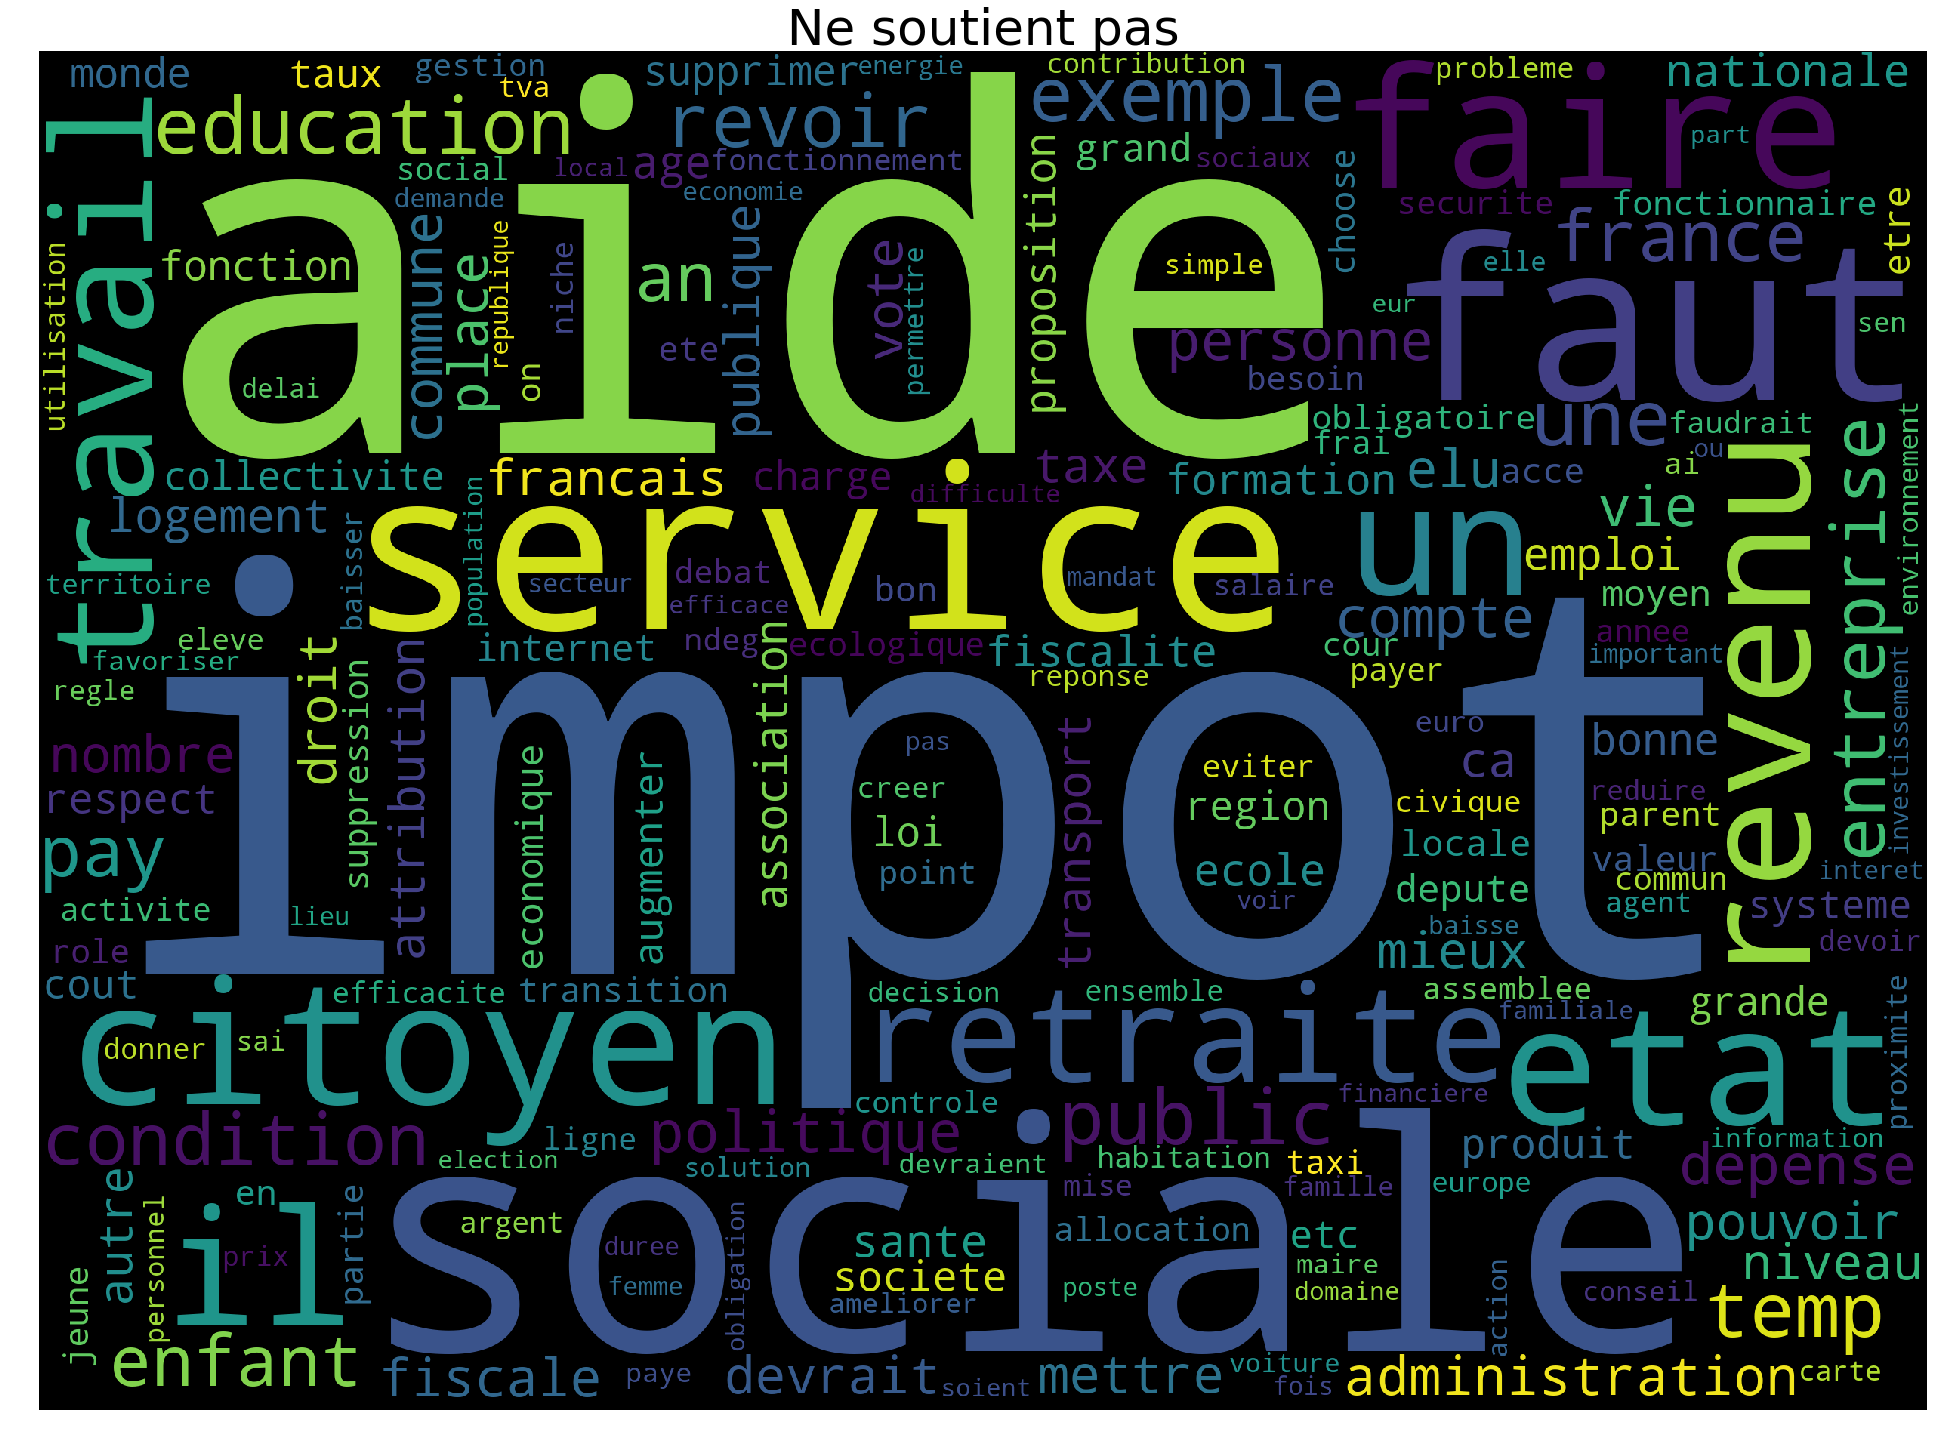

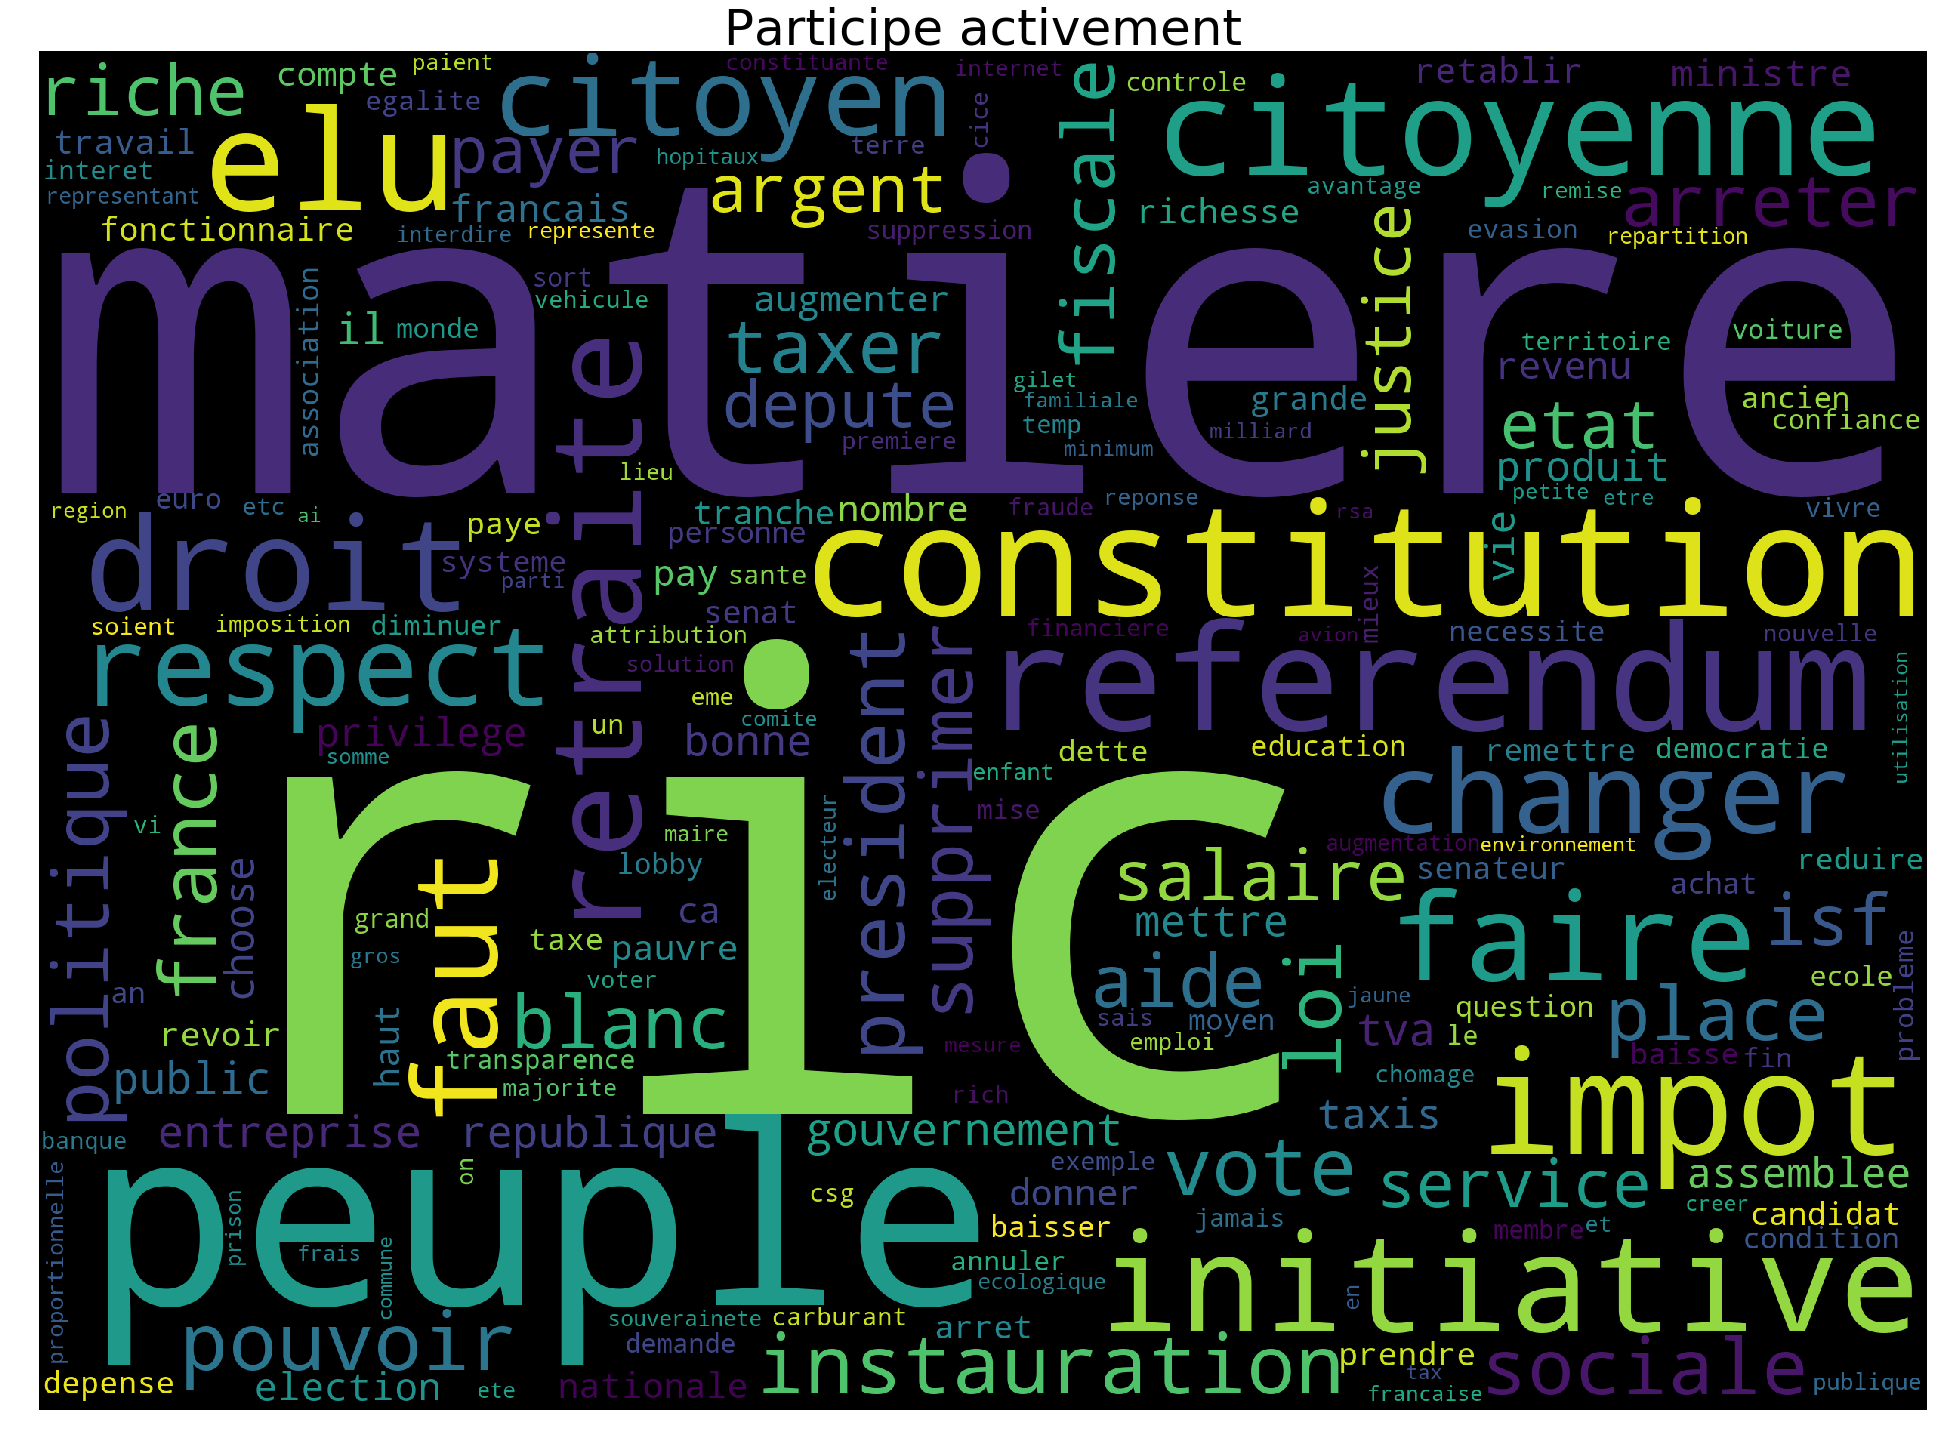

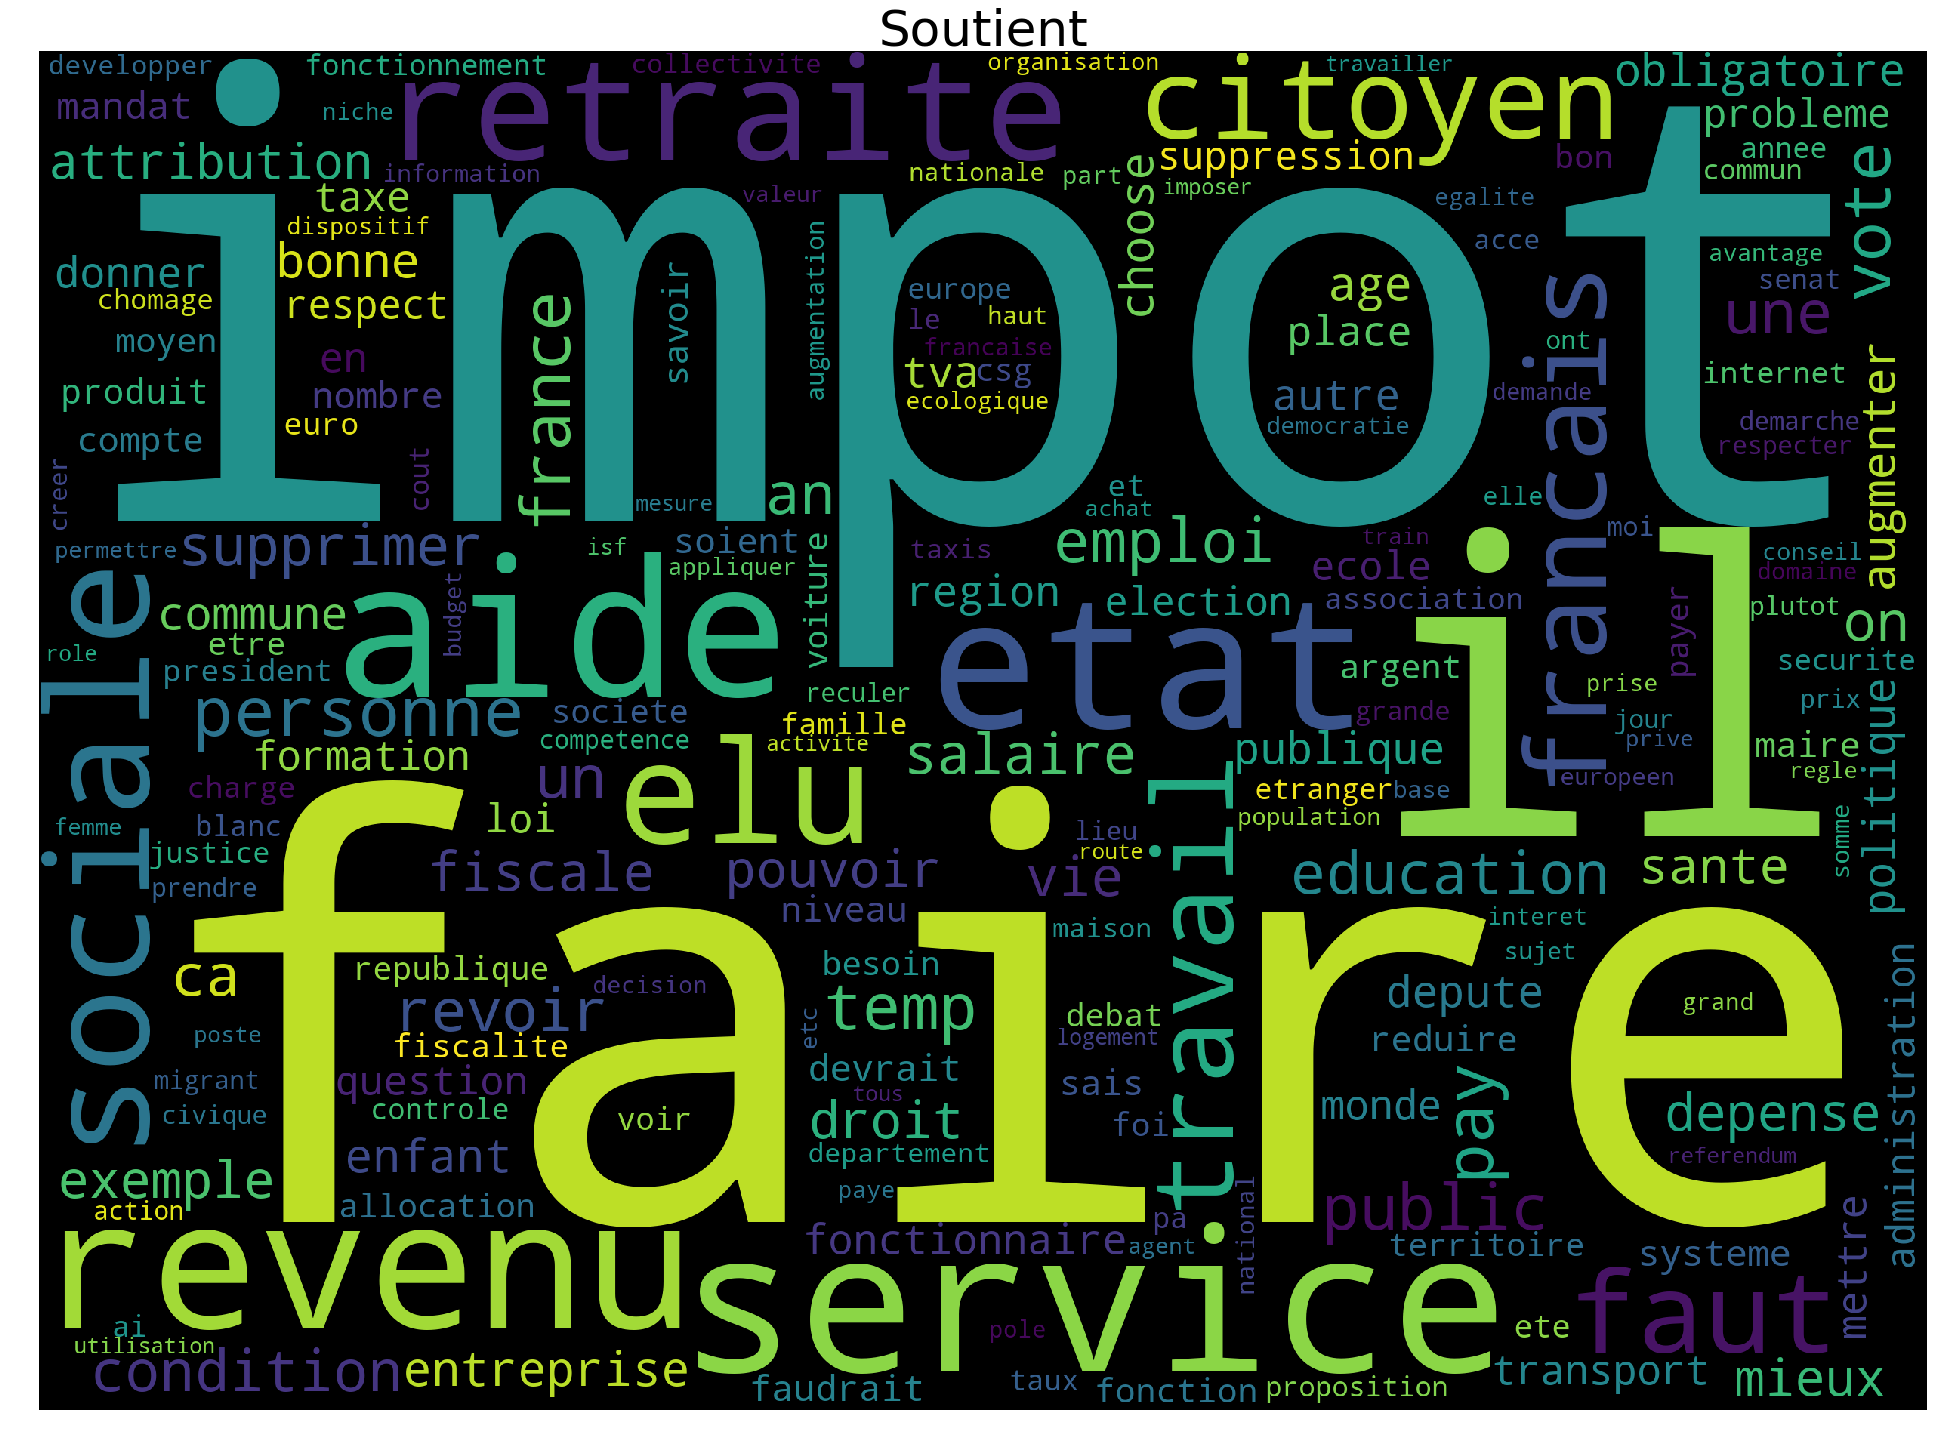

In [232]:
wordcloud_decision(model,features_contrib_test, df_author_contrib)